<a href="https://colab.research.google.com/github/lucaskermessi/Verilog/blob/main/Mips2Riscv_pipeline_Verilog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MIPS 5 Stage

This lab shows an example of a CPU **five-stage MIPS** processor, including **Hazard and Forward detection units**. The branch is solved in the fourth stage. The instruction memory should be filled in hexadecimal format. The code prints part of the internal stages such as the PC counter, instruction fields, ALU in/out, etc.
Moreover, we also shows how to display the internal signal by using **waveforms**. 


<img src="https://raw.githubusercontent.com/blindreviewsrc/blind/main/figures/mips-complete.png" alt="blind" width="600"/> 

# Install Verilog Extension

In [ ]:
!pip install git+git://github.com/lesc-ufv/cad4u.git
!git clone https://github.com/lesc-ufv/cad4u
%load_ext plugin

  Cloning git://github.com/lesc-ufv/cad4u.git to /tmp/pip-req-build-y9m02jys
  Running command git clone -q git://github.com/lesc-ufv/cad4u.git /tmp/pip-req-build-y9m02jys
  Created wheel for ColabPlugin: filename=ColabPlugin-1.0-cp37-none-any.whl size=16128 sha256=58a3b924d5062a90145f3cd0e8c6c6cd81c3b9ca079e4db459150f15a8df01de
  Stored in directory: /tmp/pip-ephem-wheel-cache-_mkmuauh/wheels/53/85/4d/41caa017fad470ffb9f2c4365364d194394851afdda7497278
Successfully built ColabPlugin
Cloning into 'cad4u'...
remote: Enumerating objects: 267, done.
remote: Counting objects: 100% (267/267), done.
remote: Compressing objects: 100% (225/225), done.
remote: Total 267 (delta 135), reused 121 (delta 29), pack-reused 0
Receiving objects: 100% (267/267), 11.02 MiB | 22.53 MiB/s, done.
Resolving deltas: 100% (135/135), done.


# Initialiaze Register File, Data and Instruction Memory

## <center> **Register File - Initial Configuration** </center>

In [ ]:
%%writefile rm_data.txt
0
01
02
03
04
05
06
07
08
09
0A
0B
0C
0D
0E
0F
10
02
03
03

Writing rm_data.txt


## <center> **Data Memory - Initial Configuration** </center>

In [ ]:
%%writefile dm_data.txt
0
1
2
03
04
05
06
07
08
09
10
11
12
13
14
15
16
17
18
19

Writing dm_data.txt


## <center> **Instruction Memory - Initial Configuration** </center>

In [ ]:
%%writefile im_data.txt
20090001
01294820
01e9502a
1140fffd
2129ffff
2129ffff
2129ffff

Writing im_data.txt


In [ ]:
!ls

alu.v	   datam.v	   execution_newcode.v	main.v	  regr.v       test.vcd
cad4u	   decodefields.v  im_data.txt		mem.data  rm_data.txt
control.v  dm_data.txt	   im_reg.v		reg.data  sample_data


# Mips Pipeline 5 stage code

## <center> **Generic n-bit Register** </center>

In [ ]:
%%writefile regr.v
module regr (	input clk,input clear,input hold,
	input wire [N-1:0] in,
	output reg [N-1:0] out);

	parameter N = 1;

	always @(posedge clk) begin
		if (clear)
			out <= {N{1'b0}};
		else if (hold)
			out <= out;
		else
			out <= in;
	end
endmodule


Overwriting regr.v


## <center> **Register File and Instruction Memory** </center>

In [ ]:
%%writefile im_reg.v
module im(input wire			clk,input wire 	[31:0] 	addr,output wire [31:0] 	data);
	parameter NMEM = 128;   // Number of memory entries,
							// not the same as the memory size
	parameter IM_DATA = "im_data.txt";  // file to read data from
	reg [31:0] mem [0:127];  // 32-bit memory with 128 entries
	initial begin
		$readmemh(IM_DATA, mem, 0, NMEM-1);
	end
	assign data = mem[addr[8:2]][31:0];
endmodule

module regm(		input wire			clk,input wire  [4:0]	read1, read2,
		output wire [31:0]	data1, data2,input wire			regwrite, input wire	[4:0]	wrreg,input wire	[31:0]	wrdata);

	parameter NMEM = 20;   // Number of memory entries,
							// not the same as the memory size
	parameter RM_DATA = "rm_data.txt";  // file to read data from

	reg [31:0] mem [0:31];  // 32-bit memory with 32 entries

	initial begin
		$readmemh(RM_DATA, mem, 0, NMEM-1);
	end
	reg [31:0] _data1, _data2;
	always @(*) begin
		if (read1 == 5'd0)
			_data1 = 32'd0;
		else if ((read1 == wrreg) && regwrite)
			_data1 = wrdata;
		else
			_data1 = mem[read1][31:0];
	end

	always @(*) begin
		if (read2 == 5'd0)
			_data2 = 32'd0;
		else if ((read2 == wrreg) && regwrite)
			_data2 = wrdata;
		else
			_data2 = mem[read2][31:0];
	end

	assign data1 = _data1;
	assign data2 = _data2;

	always @(posedge clk) begin
		if (regwrite && wrreg != 5'd0) begin
			// write a non $zero register
			mem[wrreg] <= wrdata;
		end
	end
endmodule


Overwriting im_reg.v


## <center> **ALU control and ALU** </center>



In [ ]:
%%writefile alu.v
module alu(
		input		[3:0]	ctl,
		input		[31:0]	a, b,
		output reg	[31:0]	out,
		output				zero);

	wire [31:0] sub_ab;
	wire [31:0] add_ab;
	wire 		oflow_add;
	wire 		oflow_sub;
	wire 		oflow;
	wire 		slt;

	assign zero = (0 == out);

	assign sub_ab = a - b;
	assign add_ab = a + b;
	assign oflow_add = (a[31] == b[31] && add_ab[31] != a[31]) ? 1 : 0;
	assign oflow_sub = (a[31] == b[31] && sub_ab[31] != a[31]) ? 1 : 0;
	assign oflow = (ctl == 4'b0010) ? oflow_add : oflow_sub;
	// set if less than, 2s compliment 32-bit numbers
	assign slt = oflow_sub ? ~(a[31]) : a[31];
	always @(*) begin
		case (ctl)
			4'd2:  out <= add_ab;				/* add */
			4'd0:  out <= a & b;				/* and */
			4'd12: out <= ~(a | b);				/* nor */
			4'd1:  out <= a | b;				/* or */
			4'd7:  out <= {{31{1'b0}}, slt};	/* slt */
			4'd6:  out <= sub_ab;				/* sub */
			4'd13: out <= a ^ b;				/* xor */
			default: out <= 0;
		endcase
	end

endmodule


module alu_control(
		input wire [5:0] funct,
		input wire [1:0] aluop,
		output reg [3:0] aluctl);

	reg [3:0] _funct;

	always @(*) begin
		case(funct[3:0])
			4'd0:  _funct = 4'd2;	/* add */
			4'd2:  _funct = 4'd6;	/* sub */
			4'd5:  _funct = 4'd1;	/* or */
			4'd6:  _funct = 4'd13;	/* xor */
			4'd7:  _funct = 4'd12;	/* nor */
			4'd10: _funct = 4'd7;	/* slt */
			default: _funct = 4'd0;
		endcase
	end

	always @(*) begin
		case(aluop)
			2'd0: aluctl = 4'd2;	/* add */
			2'd1: aluctl = 4'd6;	/* sub */
			2'd2: aluctl = _funct;
			2'd3: aluctl = 4'd2;	/* add */
			default: aluctl = 0;
		endcase
	end

endmodule


Overwriting alu.v


## <center> **Control Unit** </center>

In [ ]:
%%writefile control.v
module control(
		input  wire	[5:0]	opcode,
		output reg			branch_eq, branch_ne,
		output reg [1:0]	aluop,
		output reg			memread, memwrite, memtoreg,
		output reg			regdst, regwrite, alusrc,
		output reg			jump);

	always @(*) begin
		/* defaults */
		aluop[1:0]	<= 2'b10;
		alusrc		<= 1'b0;
		branch_eq	<= 1'b0;
		branch_ne	<= 1'b0;
		memread		<= 1'b0;
		memtoreg	<= 1'b0;
		memwrite	<= 1'b0;
		regdst		<= 1'b1;
		regwrite	<= 1'b1;
		jump		<= 1'b0;

		case (opcode)
			6'b100011: begin	/* lw */
				memread  <= 1'b1;
				regdst   <= 1'b0;
				memtoreg <= 1'b1;
				aluop[1] <= 1'b0;
				alusrc   <= 1'b1;
			end
			6'b001000: begin	/* addi */
				regdst   <= 1'b0;
				aluop[1] <= 1'b0;
				alusrc   <= 1'b1;
			end
			6'b000100: begin	/* beq */
				aluop[0]  <= 1'b1;
				aluop[1]  <= 1'b0;
				branch_eq <= 1'b1;
				regwrite  <= 1'b0;
			end
			6'b101011: begin	/* sw */
				memwrite <= 1'b1;
				aluop[1] <= 1'b0;
				alusrc   <= 1'b1;
				regwrite <= 1'b0;
			end
			6'b000101: begin	/* bne */
				aluop[0]  <= 1'b1;
				aluop[1]  <= 1'b0;
				branch_ne <= 1'b1;
				regwrite  <= 1'b0;
			end
			6'b000000: begin	/* add */
			end
			6'b000010: begin	/* j jump */
				jump <= 1'b1;
			end
		endcase
	end
endmodule



Overwriting control.v


## <center> **Data Memory** </center>


In [ ]:
%%writefile datam.v
module dm(
		input wire			clk,
		input wire	[6:0]	addr,
		input wire			rd, wr,
		input wire 	[31:0]	wdata,
		output wire	[31:0]	rdata);
	parameter NMEM = 20;   // Number of memory entries,
							// not the same as the memory size
	parameter RM_DATA = "dm_data.txt";  // file to read data from

	reg [31:0] mem [0:127];  // 32-bit memory with 128 entries

        initial begin
		$readmemh(RM_DATA, mem, 0, NMEM-1);
	end
		

	always @(posedge clk) begin
		if (wr) begin
			mem[addr] <= wdata;
		end
	end

	assign rdata = wr ? wdata : mem[addr];
	// During a write, avoid the one cycle delay by reading from 'wdata'

endmodule




Overwriting datam.v


## <center> **CPU five stages and Testbench** </center>

In [ ]:
%%verilog
/*
 * cpu. - five stage MIPS CPU.
 *
 */


`include "regr.v"
`include "im_reg.v"
`include "alu.v"
`include "control.v"
`include "datam.v"



module cpu(
		input wire clk);

	parameter NMEM = 7;  // number in instruction memory
	parameter IM_DATA = "im_data.txt";

	wire regwrite_s5;
	wire [4:0] wrreg_s5;
	wire [31:0]	wrdata_s5;
	reg stall_s1_s2;

	// {{{ diagnostic outputs
	initial begin
			$display("if_pc,    if_instr, id_regrs, id_regrt, ex_alua,  ex_alub,  ex_aluctl, mem_memdata, mem_memread, mem_memwrite, wb_regdata, wb_regwrite");
			$monitor("PC=%x %x||rs=%d rt=%d rd=%d||A=%x B=%x||w=%x Ram%x R%xW%x||D=%x \nb=%x j%x||Opcode=%x Func=%x||I=%x R=%x||D=%d alu=%x branch%x j%x||R=%x C=%d \n-------------------------------------------------------------------------------------------------------",
					pc,				/* if_pc */
					inst,			/* if_instr */
					rs,rt,rd,	
					fw_data1_s3,		/* A */
					alusrc_data2,	/* B */
					data2_s4,		/* mem_memdata */
					rdata,
memread_s4,		/* mem_memread */
					memwrite_s4,	
					wrdata_s5,		/* wb_wrreg */
					baddr_s4,jaddr_s4,
			                opcode, inst_s2[5:0],
					seimm_s3,alurslt,
					 wrreg_s4,alurslt_s4,	/* mem_memwrite */
					pcsrc,jump_s4,		

					wrreg_s5,		/* wb_regdata */
					clock_counter
				);
		
	end 
	// }}}

	// {{{ flush control
	reg flush_s1, flush_s2, flush_s3;
	always @(*) begin
		flush_s1 <= 1'b0;
		flush_s2 <= 1'b0;
		flush_s3 <= 1'b0;
		if (pcsrc | jump_s4) begin
			flush_s1 <= 1'b1;
			flush_s2 <= 1'b1;
			flush_s3 <= 1'b1;
		end
	end
	// }}}

	// {{{ stage 1, IF (fetch)

	reg  [5:0] clock_counter;
	initial begin
		clock_counter <= 6'd1;
	end
        always @(posedge clk) begin
                clock_counter <= clock_counter + 1;
	end

	reg  [31:0] pc;
	initial begin
		pc <= 32'd0;
	end

	wire [31:0] pc4;  // PC + 4
	assign pc4 = pc + 4;

	always @(posedge clk) begin
		if (stall_s1_s2) 
			pc <= pc;
		else if (pcsrc == 1'b1)
			pc <= baddr_s4;
		else if (jump_s4 == 1'b1)
			pc <= jaddr_s4;
		else
			pc <= pc4;
	end

	// pass PC + 4 to stage 2
	wire [31:0] pc4_s2;
	regr #(.N(32)) regr_pc4_s2(.clk(clk),
						.hold(stall_s1_s2), .clear(flush_s1),
						.in(pc4), .out(pc4_s2));

	// instruction memory
	wire [31:0] inst;
	wire [31:0] inst_s2;
	im #(.NMEM(NMEM), .IM_DATA(IM_DATA))
		im1(.clk(clk), .addr(pc), .data(inst));
	regr #(.N(32)) regr_im_s2(.clk(clk),
						.hold(stall_s1_s2), .clear(flush_s1),
						.in(inst), .out(inst_s2));

	// }}}

	// {{{ stage 2, ID (decode)

	// decode instruction
	wire [5:0]  opcode;
	wire [4:0]  rs;
	wire [4:0]  rt;
	wire [4:0]  rd;
	wire [15:0] imm;
	wire [4:0]  shamt;
	wire [31:0] jaddr_s2;
	wire [31:0] seimm;  // sign extended immediate
	//
	assign opcode   = inst_s2[31:26];
	assign rs       = inst_s2[25:21];
	assign rt       = inst_s2[20:16];
	assign rd       = inst_s2[15:11];
	assign imm      = inst_s2[15:0];
	assign shamt    = inst_s2[10:6];
	assign jaddr_s2 = {pc[31:28], inst_s2[25:0], {2{1'b0}}};
	assign seimm 	= {{16{inst_s2[15]}}, inst_s2[15:0]};

	// register memory
	wire [31:0] data1, data2;
	regm regm1(.clk(clk), .read1(rs), .read2(rt),
			.data1(data1), .data2(data2),
			.regwrite(regwrite_s5), .wrreg(wrreg_s5),
			.wrdata(wrdata_s5));

	// pass rs to stage 3 (for forwarding)
	wire [4:0] rs_s3;
	regr #(.N(5)) regr_s2_rs(.clk(clk), .clear(1'b0), .hold(stall_s1_s2),
				.in(rs), .out(rs_s3));

	// transfer register data to stage 3
	wire [31:0]	data1_s3, data2_s3;
	regr #(.N(64)) reg_s2_mem(.clk(clk), .clear(flush_s2), .hold(stall_s1_s2),
				.in({data1, data2}),
				.out({data1_s3, data2_s3}));

	// transfer seimm, rt, and rd to stage 3
	wire [31:0] seimm_s3;
	wire [4:0] 	rt_s3;
	wire [4:0] 	rd_s3;
	regr #(.N(32)) reg_s2_seimm(.clk(clk), .clear(flush_s2), .hold(stall_s1_s2),
						.in(seimm), .out(seimm_s3));
	regr #(.N(10)) reg_s2_rt_rd(.clk(clk), .clear(flush_s2), .hold(stall_s1_s2),
						.in({rt, rd}), .out({rt_s3, rd_s3}));

	// transfer PC + 4 to stage 3
	wire [31:0] pc4_s3;
	regr #(.N(32)) reg_pc4_s2(.clk(clk), .clear(1'b0), .hold(stall_s1_s2),
						.in(pc4_s2), .out(pc4_s3));

	// control (opcode -> ...)
	wire		regdst;
	wire		branch_eq_s2;
	wire		branch_ne_s2;
	wire		memread;
	wire		memwrite;
	wire		memtoreg;
	wire [1:0]	aluop;
	wire		regwrite;
	wire		alusrc;
	wire		jump_s2;
	//
	control ctl1(.opcode(opcode), .regdst(regdst),
				.branch_eq(branch_eq_s2), .branch_ne(branch_ne_s2),
				.memread(memread),
				.memtoreg(memtoreg), .aluop(aluop),
				.memwrite(memwrite), .alusrc(alusrc),
				.regwrite(regwrite), .jump(jump_s2));

	// shift left, seimm
	wire [31:0] seimm_sl2;
	assign seimm_sl2 = {seimm[29:0], 2'b0};  // shift left 2 bits
	// branch address
	wire [31:0] baddr_s2;
	assign baddr_s2 = pc4_s2 + seimm_sl2;

	// transfer the control signals to stage 3
	wire		regdst_s3;
	wire		memread_s3;
	wire		memwrite_s3;
	wire		memtoreg_s3;
	wire [1:0]	aluop_s3;
	wire		regwrite_s3;
	wire		alusrc_s3;
	// A bubble is inserted by setting all the control signals
	// to zero (stall_s1_s2).
	regr #(.N(8)) reg_s2_control(.clk(clk), .clear(stall_s1_s2), .hold(1'b0),
			.in({regdst, memread, memwrite,
					memtoreg, aluop, regwrite, alusrc}),
			.out({regdst_s3, memread_s3, memwrite_s3,
					memtoreg_s3, aluop_s3, regwrite_s3, alusrc_s3}));

	wire branch_eq_s3, branch_ne_s3;
	regr #(.N(2)) branch_s2_s3(.clk(clk), .clear(flush_s2), .hold(1'b0),
				.in({branch_eq_s2, branch_ne_s2}),
				.out({branch_eq_s3, branch_ne_s3}));

	wire [31:0] baddr_s3;
	regr #(.N(32)) baddr_s2_s3(.clk(clk), .clear(flush_s2), .hold(1'b0),
				.in(baddr_s2), .out(baddr_s3));

	wire jump_s3;
	regr #(.N(1)) reg_jump_s3(.clk(clk), .clear(flush_s2), .hold(1'b0),
				.in(jump_s2),
				.out(jump_s3));

	wire [31:0] jaddr_s3;
	regr #(.N(32)) reg_jaddr_s3(.clk(clk), .clear(flush_s2), .hold(1'b0),
				.in(jaddr_s2), .out(jaddr_s3));
	// }}}

	// {{{ stage 3, EX (execute)

	// pass through some control signals to stage 4
	wire regwrite_s4;
	wire memtoreg_s4;
	wire memread_s4;
	wire memwrite_s4;
	regr #(.N(4)) reg_s3(.clk(clk), .clear(flush_s2), .hold(1'b0),
				.in({regwrite_s3, memtoreg_s3, memread_s3,
						memwrite_s3}),
				.out({regwrite_s4, memtoreg_s4, memread_s4,
						memwrite_s4}));

	// ALU
	// second ALU input can come from an immediate value or data
	wire [31:0] alusrc_data2;
	assign alusrc_data2 = (alusrc_s3) ? seimm_s3 : fw_data2_s3;
	// ALU control
	wire [3:0] aluctl;
	wire [5:0] funct;
	assign funct = seimm_s3[5:0];
	alu_control alu_ctl1(.funct(funct), .aluop(aluop_s3), .aluctl(aluctl));
	// ALU
	wire [31:0]	alurslt;
	reg [31:0] fw_data1_s3;
	always @(*)
	case (forward_a)
			2'd1: fw_data1_s3 = alurslt_s4;
			2'd2: fw_data1_s3 = wrdata_s5;
		 default: fw_data1_s3 = data1_s3;
	endcase
	wire zero_s3;
	alu alu1(.ctl(aluctl), .a(fw_data1_s3), .b(alusrc_data2), .out(alurslt),
									.zero(zero_s3));
	wire zero_s4;
	regr #(.N(1)) reg_zero_s3_s4(.clk(clk), .clear(1'b0), .hold(1'b0),
					.in(zero_s3), .out(zero_s4));

	// pass ALU result and zero to stage 4
	wire [31:0]	alurslt_s4;
	regr #(.N(32)) reg_alurslt(.clk(clk), .clear(flush_s3), .hold(1'b0),
				.in({alurslt}),
				.out({alurslt_s4}));

	// pass data2 to stage 4
	wire [31:0] data2_s4;
	reg [31:0] fw_data2_s3;
	always @(*)
	case (forward_b)
			2'd1: fw_data2_s3 = alurslt_s4;
			2'd2: fw_data2_s3 = wrdata_s5;
		 default: fw_data2_s3 = data2_s3;
	endcase
	regr #(.N(32)) reg_data2_s3(.clk(clk), .clear(flush_s3), .hold(1'b0),
				.in(fw_data2_s3), .out(data2_s4));

	// write register
	wire [4:0]	wrreg;
	wire [4:0]	wrreg_s4;
	assign wrreg = (regdst_s3) ? rd_s3 : rt_s3;
	// pass to stage 4
	regr #(.N(5)) reg_wrreg(.clk(clk), .clear(flush_s3), .hold(1'b0),
				.in(wrreg), .out(wrreg_s4));

	wire branch_eq_s4, branch_ne_s4;
	regr #(.N(2)) branch_s3_s4(.clk(clk), .clear(flush_s3), .hold(1'b0),
				.in({branch_eq_s3, branch_ne_s3}),
				.out({branch_eq_s4, branch_ne_s4}));

	wire [31:0] baddr_s4;
	regr #(.N(32)) baddr_s3_s4(.clk(clk), .clear(flush_s3), .hold(1'b0),
				.in(baddr_s3), .out(baddr_s4));

	wire jump_s4;
	regr #(.N(1)) reg_jump_s4(.clk(clk), .clear(flush_s3), .hold(1'b0),
				.in(jump_s3),
				.out(jump_s4));

	wire [31:0] jaddr_s4;
	regr #(.N(32)) reg_jaddr_s4(.clk(clk), .clear(flush_s3), .hold(1'b0),
				.in(jaddr_s3), .out(jaddr_s4));
	// }}}

	// {{{ stage 4, MEM (memory)

	// pass regwrite and memtoreg to stage 5
	wire memtoreg_s5;
	regr #(.N(2)) reg_regwrite_s4(.clk(clk), .clear(1'b0), .hold(1'b0),
				.in({regwrite_s4, memtoreg_s4}),
				.out({regwrite_s5, memtoreg_s5}));

	// data memory
	wire [31:0] rdata;
	dm dm1(.clk(clk), .addr(alurslt_s4[8:2]), .rd(memread_s4), .wr(memwrite_s4),
			.wdata(data2_s4), .rdata(rdata));
	// pass read data to stage 5
	wire [31:0] rdata_s5;
	regr #(.N(32)) reg_rdata_s4(.clk(clk), .clear(1'b0), .hold(1'b0),
				.in(rdata),
				.out(rdata_s5));

	// pass alurslt to stage 5
	wire [31:0] alurslt_s5;
	regr #(.N(32)) reg_alurslt_s4(.clk(clk), .clear(1'b0), .hold(1'b0),
				.in(alurslt_s4),
				.out(alurslt_s5));

	// pass wrreg to stage 5
	regr #(.N(5)) reg_wrreg_s4(.clk(clk), .clear(1'b0), .hold(1'b0),
				.in(wrreg_s4),
				.out(wrreg_s5));

	// branch
	reg pcsrc;
	always @(*) begin
		case (1'b1)
			branch_eq_s4: pcsrc <= zero_s4;
			branch_ne_s4: pcsrc <= ~(zero_s4);  // Aproveitar o bne para o blt
      // branch_lt_s4: pcsrc <= alurslt_s4[31];
			default: pcsrc <= 1'b0;
		endcase
	end
	// }}}
			
	// {{{ stage 5, WB (write back)

	assign wrdata_s5 = (memtoreg_s5 == 1'b1) ? rdata_s5 : alurslt_s5;

	// }}}

	// {{{ forwarding

	// stage 3 (MEM) -> stage 2 (EX)
	// stage 4 (WB) -> stage 2 (EX)

	reg [1:0] forward_a;
	reg [1:0] forward_b;
	always @(*) begin
		// If the previous instruction (stage 4) would write,
		// and it is a value we want to read (stage 3), forward it.

		// data1 input to ALU
		if ((regwrite_s4 == 1'b1) && (wrreg_s4 == rs_s3)) begin
			forward_a <= 2'd1;  // stage 4
		end else if ((regwrite_s5 == 1'b1) && (wrreg_s5 == rs_s3)) begin
			forward_a <= 2'd2;  // stage 5
		end else
			forward_a <= 2'd0;  // no forwarding

		// data2 input to ALU
		if ((regwrite_s4 == 1'b1) & (wrreg_s4 == rt_s3)) begin
			forward_b <= 2'd1;  // stage 5
		end else if ((regwrite_s5 == 1'b1) && (wrreg_s5 == rt_s3)) begin
			forward_b <= 2'd2;  // stage 5
		end else
			forward_b <= 2'd0;  // no forwarding
	end
	// }}}

	// {{{ load use data hazard detection, signal stall

	/* If an operation in stage 4 (MEM) loads from memory (e.g. lw)
	 * and the operation in stage 3 (EX) depends on this value,
	 * a stall must be performed.  The memory read cannot 
	 * be forwarded because memory access is too slow.  It can
	 * be forwarded from stage 5 (WB) after a stall.
	 *
	 *   lw $1, 16($10)  ; I-type, rt_s3 = $1, memread_s3 = 1
	 *   sw $1, 32($12)  ; I-type, rt_s2 = $1, memread_s2 = 0
	 *
	 *   lw $1, 16($3)  ; I-type, rt_s3 = $1, memread_s3 = 1
	 *   sw $2, 32($1)  ; I-type, rt_s2 = $2, rs_s2 = $1, memread_s2 = 0
	 *
	 *   lw  $1, 16($3)  ; I-type, rt_s3 = $1, memread_s3 = 1
	 *   add $2, $1, $1  ; R-type, rs_s2 = $1, rt_s2 = $1, memread_s2 = 0
	 */
	always @(*) begin
		if (memread_s3 == 1'b1 && ((rt == rt_s3) || (rs == rt_s3)) ) begin
			stall_s1_s2 <= 1'b1;  // perform a stall
		end else
			stall_s1_s2 <= 1'b0;  // no stall
	end
	// }}}

endmodule


module top;
reg clk;

initial begin
  clk=0;
     forever #1 clk = ~clk;  
end 

cpu CPU(clk);
initial begin
    $dumpfile("test.vcd");
    $dumpvars(0,top);
    #70
    $finish;
    end

endmodule


if_pc,    if_instr, id_regrs, id_regrt, ex_alua,  ex_alub,  ex_aluctl, mem_memdata, mem_memread, mem_memwrite, wb_regdata, wb_regwrite
VCD info: dumpfile test.vcd opened for output.
PC=00000000 20090001||rs= x rt= x rd= x||A=xxxxxxxx B=xxxxxxxx||w=xxxxxxxx Ramxxxxxxxx RxWx||D=xxxxxxxx 
b=xxxxxxxx jxxxxxxxx||Opcode=xx Func=xx||I=xxxxxxxx R=xxxxxxxx||D= x alu=xxxxxxxx branchx jx||R=xx C= 1 
-------------------------------------------------------------------------------------------------------
PC=00000004 01294820||rs= 0 rt= 9 rd= 0||A=xxxxxxxx B=xxxxxxxx||w=xxxxxxxx Ramxxxxxxxx RxWx||D=xxxxxxxx 
b=xxxxxxxx jxxxxxxxx||Opcode=08 Func=01||I=xxxxxxxx R=xxxxxxxx||D= x alu=xxxxxxxx branchx jx||R=xx C= 2 
-------------------------------------------------------------------------------------------------------
PC=00000008 01e9502a||rs= 9 rt= 9 rd= 9||A=00000000 B=00000001||w=xxxxxxxx Ramxxxxxxxx RxWx||D=xxxxxxxx 
b=xxxxxxxx j0xxxxxxX||Opcode=00 Func=20||I=00000001 R=00000001||D= x alu=xxxxxxxx bra

## <center> **Waveform Debug Example** </center>

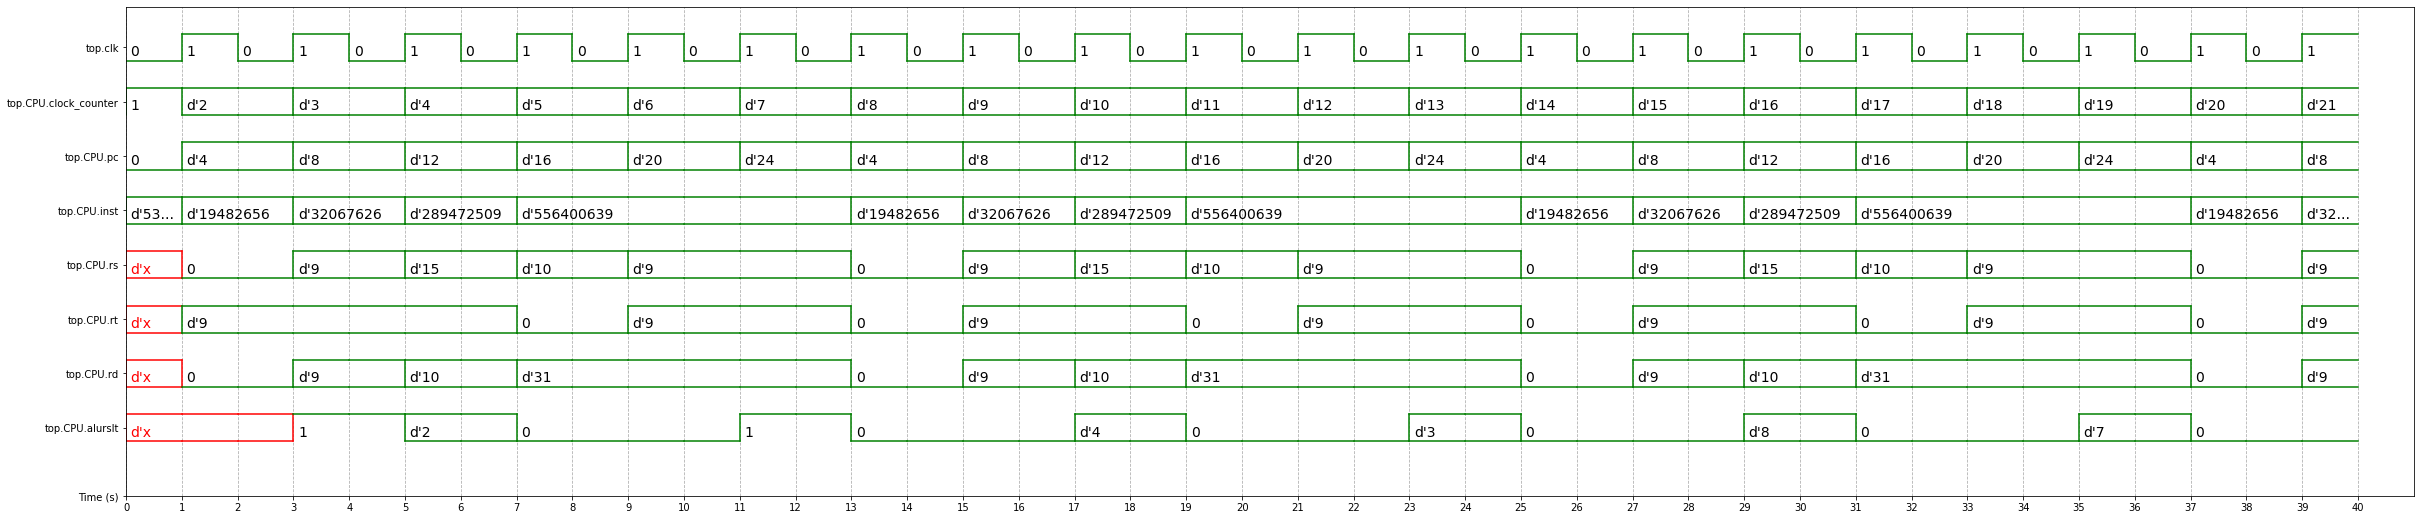

In [ ]:
%%waveform test.vcd

sign_list = ['top.clk','top.CPU.clock_counter','top.CPU.pc','top.CPU.inst', 'top.CPU.rs','top.CPU.rt', 'top.CPU.rd','top.CPU.alurslt' ]
time_begin = 0
time_end = 40
base = 'dec' # bin, dec, dec2, hex, octal


# Risc-V

## Register File

In [ ]:
%%writefile rm_data.txt
0
01
02
03
04
05
06
07
08
09
0A
0B
0C
0D
0E
0F
10
11
12
13

Overwriting rm_data.txt


## Data Memory

In [ ]:
%%writefile dm_data.txt
0
1
2
03
04
05
06
07
08
09
10
11
12
13
14
15
16
17
18
19

Overwriting dm_data.txt


## Instruction Memory

### Montador

[Risc-V assembler](https://www.riscvassembler.org/index.html#install)

In [ ]:
!pip install riscv-assembler

     |████████████████████████████████| 204kB 13.2MB/s 
  Created wheel for riscv-assembler: filename=riscv_assembler-1.0.14-cp37-none-any.whl size=9215 sha256=ef3d2c4d1a947f191f4f4326db3c58716e9c0909d26b084b1e23876547948fe8
  Stored in directory: /root/.cache/pip/wheels/40/ba/fd/e06a025d78cf7de5bff9e6387ccd2e82876aa0ba41c5ebbb40
  Created wheel for bitstring: filename=bitstring-3.1.7-cp37-none-any.whl size=37949 sha256=27e56e1d5353a7e3a46c8bdf06320faaa89f83f1da61a93e28b7aad01a5e6955
  Stored in directory: /root/.cache/pip/wheels/b8/27/f0/8373e26b7de57db03dc18aaaebdd8c26a99da882416f762979
Successfully built riscv-assembler bitstring


#### Code

Type your code and execute the following lines.

#### Programas de Testes

In [ ]:
%%writefile simple.s
add x1,x2,x3
add x4,x5,x6
add x7,x8,x9
sub x10,x11,x12
add x1,x1,x1

Writing simple.s


In [ ]:
from riscv_assembler.convert import AssemblyConverter
!rm -f -r simple/*
cnv = AssemblyConverter(output_type = "t") #just text
cnv.convert("simple.s")
# Using readlines()
file1 = open('simple/txt/simple.txt', 'r')
Lines = file1.readlines()
file1 = open('im_data.txt', 'w')


for line in Lines:
   decimal_representation = int(line, 2)
   hexadecimal_string = hex(decimal_representation)
   file1.write(hexadecimal_string[2:]+'\n')

file1.close()

0
------Writing to Text file------
Output file: simple.txt
Number of instructions: 5


In [ ]:
!cat simple/txt/simple.txt

00000000001100010000000010110011
00000000011000101000001000110011
00000000100101000000001110110011
01000000110001011000010100110011
00000000000100001000000010110011


In [ ]:
!cat im_data.txt

20090001
01294820
01e9502a
1140fffd
2129ffff
2129ffff
2129ffff

### Or type your hexa RiscV instructions

In [ ]:
%%writefile im_data.txt
20090001
01294820
01e9502a
1140fffd
2129ffff
2129ffff
2129ffff

Overwriting im_data.txt


# RiscV 5 stage code

## Generic Register File

In [ ]:
%%writefile regr.v
module regr (	input clk,input clear,input hold,
	input wire [N-1:0] in,
	output reg [N-1:0] out);

	parameter N = 1;

	always @(posedge clk) begin
		if (clear)
			out <= {N{1'b0}};
		else if (hold)
			out <= out;
		else
			out <= in;
	end
endmodule


Overwriting regr.v


## Register File and Instruction Memory

In [ ]:
%%writefile im_reg.v
module im(input wire			clk,input wire 	[31:0] 	addr,output wire [31:0] 	data);
	parameter NMEM = 128;   // Number of memory entries,
							// not the same as the memory size
	parameter IM_DATA = "im_data.txt";  // file to read data from
	reg [31:0] mem [0:127];  // 32-bit memory with 128 entries
	initial begin
		$readmemh(IM_DATA, mem, 0, NMEM-1);
	end
	assign data = mem[addr[8:2]][31:0];
endmodule

module regm(		input wire			clk,input wire  [4:0]	read1, read2,
		output wire [31:0]	data1, data2,input wire			regwrite, input wire	[4:0]	wrreg,input wire	[31:0]	wrdata);

	parameter NMEM = 20;   // Number of memory entries,
							// not the same as the memory size
	parameter RM_DATA = "rm_data.txt";  // file to read data from

	reg [31:0] mem [0:31];  // 32-bit memory with 32 entries

	initial begin
		$readmemh(RM_DATA, mem, 0, NMEM-1);
	end
	reg [31:0] _data1, _data2;
	always @(*) begin
		if (read1 == 5'd0)
			_data1 = 32'd0;
		else if ((read1 == wrreg) && regwrite)
			_data1 = wrdata;
		else
			_data1 = mem[read1][31:0];
	end

	always @(*) begin
		if (read2 == 5'd0)
			_data2 = 32'd0;
		else if ((read2 == wrreg) && regwrite)
			_data2 = wrdata;
		else
			_data2 = mem[read2][31:0];
	end

	assign data1 = _data1;
	assign data2 = _data2;

	always @(posedge clk) begin
		if (regwrite && wrreg != 5'd0) begin
			// write a non $zero register
			mem[wrreg] <= wrdata;
		end
	end
endmodule


Overwriting im_reg.v


## Data Memory

In [ ]:
%%writefile datam.v
module dm(
		input wire			clk,
		input wire	[6:0]	addr,
		input wire			rd, wr,
		input wire 	[31:0]	wdata,
		output wire	[31:0]	rdata);
	parameter NMEM = 20;   // Number of memory entries,
							// not the same as the memory size
	parameter RM_DATA = "dm_data.txt";  // file to read data from

	reg [31:0] mem [0:127];  // 32-bit memory with 128 entries

        initial begin
		$readmemh(RM_DATA, mem, 0, NMEM-1);
	end
		

	always @(posedge clk) begin
		if (wr) begin
			mem[addr] <= wdata;
		end
	end

	assign rdata = wr ? wdata : mem[addr];
	// During a write, avoid the one cycle delay by reading from 'wdata'

endmodule




Overwriting datam.v


## **Alu Control and Alu**

Update funct3 and funct7 logic, new instructions.

In [ ]:
%%writefile alu.v
module alu(
		input		[3:0]	ctl,
		input		[31:0]	a, b,
		output reg	[31:0]	out,
		output				zero);

	wire [31:0] sub_ab;
	wire [31:0] add_ab;
	wire 		oflow_add;
	wire 		oflow_sub;
	wire 		oflow;
	wire 		slt;

	assign zero = (0 == out);

	assign sub_ab = a - b;
	assign add_ab = a + b;
	assign oflow_add = (a[31] == b[31] && add_ab[31] != a[31]) ? 1 : 0;
	assign oflow_sub = (a[31] == b[31] && sub_ab[31] != a[31]) ? 1 : 0;
	assign oflow = (ctl == 4'b0010) ? oflow_add : oflow_sub;
	// set if less than, 2s compliment 32-bit numbers
	assign slt = oflow_sub ? ~(a[31]) : a[31];
	always @(*) begin
		case (ctl)
			4'd2:  out <= add_ab;				/* add */
			4'd0:  out <= a & b;				/* and */
			4'd12: out <= ~(a | b);				/* nor */
			4'd1:  out <= a | b;				/* or */
			4'd7:  out <= {{31{1'b0}}, slt};	/* slt */
			4'd6:  out <= sub_ab;				/* sub */
			4'd13: out <= a ^ b;				/* xor */
			default: out <= 0;
		endcase
	end

endmodule


module alu_control(
		input wire [3:0] funct,
		input wire [1:0] aluop,
		output reg [3:0] aluctl);

	reg [3:0] _funct;

	always @(*) begin
		case(funct[3:0])
			4'd0:  _funct = 4'd2;	/* add */
			4'd8:  _funct = 4'd6;	/* sub */
			4'd5:  _funct = 4'd1;	/* or */
			4'd6:  _funct = 4'd13;	/* xor */
			4'd7:  _funct = 4'd12;	/* nor */
			4'd10: _funct = 4'd7;	/* slt */
			default: _funct = 4'd0;
		endcase
	end

	always @(*) begin
		case(aluop)
			2'd0: aluctl = 4'd2;	/* add */
			2'd1: aluctl = 4'd6;	/* sub */
			2'd2: aluctl = _funct;
			2'd3: aluctl = 4'd2;	/* add */
			default: aluctl = 0;
		endcase
	end

endmodule


Overwriting alu.v


## **Control Unit**

Update Opcode and control signals

In [ ]:
%%writefile control.v
module control(
		input  wire	[6:0]	opcode,
		output reg			branch_eq, branch_ne, branch_lt,
		output reg [1:0]	aluop,
		output reg			memread, memwrite, memtoreg,
		output reg			regdst, regwrite, alusrc,
		output reg			jump,
    output reg [31:0] ImmGen,
    input [31:0] inst);

	always @(*) begin
		/* defaults */
		aluop[1:0]	<= 2'b10;
		alusrc		<= 1'b0;
		branch_eq	<= 1'b0;
		branch_ne	<= 1'b0;
    branch_lt	<= 1'b0;
		memread		<= 1'b0;
		memtoreg	<= 1'b0;
		memwrite	<= 1'b0;
		regdst		<= 1'b1;
		regwrite	<= 1'b1;
		jump		<= 1'b0;

		case (opcode)
     7'b0000011: begin // lw == 3
        	alusrc   <= 1'b1;
          aluop[1:0]	<= 2'b00;
        	memtoreg <= 1'b1;                 
        	regwrite <= 1'b1; 
        	memread  <= 1'b1;
        	ImmGen   <= {{20{inst[31]}},inst[31:20]};
      	end
			7'b0010011: begin	/* addi */
				//regdst   <= 1'b0; // rt or rd (only mips)
				aluop[1] <= 1'b0;
				alusrc   <= 1'b1;
        ImmGen   <= {{20{inst[31]}},inst[31:20]};
			end
      7'b1100011: begin // beq == 99
          aluop  <= 2'b1;
    	    ImmGen   <= {{19{inst[31]}},inst[31],inst[7],inst[30:25],inst[11:8],1'b0};
          regwrite  <= 1'b0;
          if(inst[14:12]== 3'b0)
            branch_eq <= 1'b1;
          else if(inst[14:12] == 3'b1)
            branch_ne <= 1'b1;
		  end
			7'b0100011: begin	/* sw */
				memwrite <= 1'b1;
				aluop[1] <= 1'b0;
				alusrc   <= 1'b1;
				regwrite <= 1'b0;
        ImmGen   <= {{20{inst[31]}},inst[31:25],inst[11:7]};
			end
			6'b000101: begin	/* bne */
				aluop[0]  <= 1'b1;
				aluop[1]  <= 1'b0;
        regwrite  <= 1'b0;
				branch_ne <= 1'b1;
			end
			7'b0110011: begin	/* add */
			end
			6'b000010: begin	/* j jump */
				jump <= 1'b1;
			end
		endcase
	end
endmodule



Overwriting control.v


<img src="https://raw.githubusercontent.com/cacauvicosa/mips/master/michael/riscv/riscv-single/riscv-single.png" width="600">

## RISCV Processor

To be update:
1. Add and Sub instructions
2. Addi instructions
3. Load and Store Instructions
4. Beq and Bne Instructions

[Colab single Risc-V](https://colab.research.google.com/drive/1EA-Vml_wUO2pcQwySh15ibjn_UPqjSvO?usp=sharing#scrollTo=HcbGSRJjPCBB)

[Slide Cap4](https://docs.google.com/presentation/d/1ztqfccs7TybpBk6Xqyg3BRS_BEc2WtihyqBCcf3xrYM/edit#slide=id.p2)


### MIPS & RiscV Opcodes bits and Registers


<img src="https://raw.githubusercontent.com/arduinoufv/inf251/main/figures/mips_opcode_regs.png" alt="wscad2020" width="300"/>  <img src="https://raw.githubusercontent.com/arduinoufv/inf251/main/figures/riscV_opcode_regs.png" alt="wscad2020" width="300"/> 

### New Decode code

In [ ]:
%%writefile decodefields.v
wire [5:0]  opcode; wire [6:0]  opcoderv; 
	wire [4:0]  rs;     wire [4:0]  rs1;
	wire [4:0]  rt;     wire [4:0]  rs2;
	wire [4:0]  rd;
                      wire [6:0] func7; wire [2:0] func3;
	wire [15:0] imm;
	wire [4:0]  shamt;
	wire [31:0] jaddr_s2;
	wire [31:0] seimm;  // sign extended immediate
	//
	assign opcode   = inst_s2[31:26];  assign opcoderv   = inst_s2[6:0]; 
	assign rs       = inst_s2[25:21];  assign rs2       = inst_s2[24:20];
	assign rt       = inst_s2[20:16];  assign rs1       = inst_s2[19:15];
	assign rd       = inst_s2[11:7];
                                      assign func7       = inst_s2[31:25];
                                      assign func3       = inst_s2[14:12];
	assign imm      = inst_s2[15:0];
	assign shamt    = inst_s2[10:6];
	assign jaddr_s2 = {pc[31:28], inst_s2[25:0], {2{1'b0}}};
	assign seimm 	= {{16{inst_s2[15]}}, inst_s2[15:0]};

  // register file
	wire [31:0] data1, data2;
	regm regm1(.clk(clk), .read1(rs1), .read2(rs2),
			.data1(data1), .data2(data2),
			.regwrite(regwrite_s5), .wrreg(wrreg_s5),
			.wrdata(wrdata_s5));

      // control (opcode -> ...)
	wire		regdst;
	wire		branch_eq_s2;
	wire		branch_ne_s2;
	wire		memread;
	wire		memwrite;
	wire		memtoreg;
	wire [1:0]	aluop;
	wire		regwrite;
	wire		alusrc;
	wire		jump_s2;
  wire [31:0] ImmGen;  // RISCV
	//
	control ctl1(.opcode(opcoderv), .regdst(regdst),
				.branch_eq(branch_eq_s2), .branch_ne(branch_ne_s2),
				.memread(memread),
				.memtoreg(memtoreg), .aluop(aluop),
				.memwrite(memwrite), .alusrc(alusrc),
				.regwrite(regwrite), .jump(jump_s2), .ImmGen(ImmGen), .inst(inst_s2));

  	// pass rs to stage 3 (for forwarding)
	wire [4:0] rs_s3;     	wire [4:0] rs1_s3;
	regr #(.N(5)) regr_s2_rs(.clk(clk), .clear(1'b0), .hold(stall_s1_s2),
				.in(rs1), .out(rs1_s3));

	// transfer seimm, rt, and rd to stage 3
	wire [31:0] seimm_s3;
	wire [4:0] 	rt_s3;    wire [4:0] rs2_s3;
	wire [4:0] 	rd_s3;
	regr #(.N(32)) reg_s2_seimm(.clk(clk), .clear(flush_s2), .hold(stall_s1_s2),
						.in(ImmGen), .out(seimm_s3));  // RISCV
	regr #(.N(10)) reg_s2_rt_rd(.clk(clk), .clear(flush_s2), .hold(stall_s1_s2),
						.in({rs2, rd}), .out({rs2_s3, rd_s3}));

  // shift left, seimm
	wire [31:0] seimm_sl2;
	assign seimm_sl2 = {seimm[29:0], 2'b0};  // shift left 2 bits
	// branch address
	wire [31:0] baddr_s2;
	assign baddr_s2 = pc4_s2 + ImmGen;

  wire [3:0] func_s3;
  
  	regr #(.N(4)) func7_3_s2(.clk(clk), .clear(1'b0), .hold(stall_s1_s2),
						.in({func7[5],func3}), .out(func_s3));




Overwriting decodefields.v


### MIPS & RiscV Immediate and Funct Alucontrol

<img src="https://raw.githubusercontent.com/arduinoufv/inf251/main/figures/mips_imgen_aluctrl.png" alt="wscad2020" width="300"/>  <img src="https://raw.githubusercontent.com/arduinoufv/inf251/main/figures/imgen_aluctrl_RiscV.png" alt="wscad2020" width="300"/> 

### Execution Stage

In [ ]:
%%writefile execution_newcode.v
// ALU
	// second ALU input can come from an immediate value or data
	wire [31:0] alusrc_data2;
	assign alusrc_data2 = (alusrc_s3) ? seimm_s3 : fw_data2_s3;
	// ALU control
	wire [3:0] aluctl;
	wire [5:0] funct;
	assign funct = seimm_s3[5:0];
	alu_control alu_ctl1(.funct(func_s3), .aluop(aluop_s3), .aluctl(aluctl));
	// ALU
	wire [31:0]	alurslt;
  wire zero_s3;
	alu alu1(.ctl(aluctl), .a(fw_data1_s3), .b(alusrc_data2), .out(alurslt),
									.zero(zero_s3));

                  	// write register
	wire [4:0]	wrreg;
	wire [4:0]	wrreg_s4;
	assign wrreg = (regdst_s3) ? rd_s3 : rs2_s3;


Overwriting execution_newcode.v


### MIPS & RISCV  Instruction Format

<img src="https://raw.githubusercontent.com/arduinoufv/inf251/main/figures/mips_formato_instrucoes.png" alt="wscad2020" width="500"/>  <img src="https://raw.githubusercontent.com/arduinoufv/inf251/main/figures/riscVaddsubaddildsd.png" alt="wscad2020" width="500"/> 

### DATAPATH (without few wires...)

<img src="https://raw.githubusercontent.com/arduinoufv/inf251/main/figures/riscvhazard_forward.png" alt="wscad2020" width="800"/> 


### main code

In [ ]:
%%writefile main.v
/*
 * cpu. - five stage MIPS CPU.
 *
 */


`include "regr.v"
`include "im_reg.v"
`include "alu.v"
`include "control.v"
`include "datam.v"



module cpu(
		input wire clk);

	parameter NMEM = 7;  // number in instruction memory
	parameter IM_DATA = "im_data.txt";

	wire regwrite_s5;
	wire [4:0] wrreg_s5;
	wire [31:0]	wrdata_s5;
	reg stall_s1_s2;

	// {{{ flush control
	reg flush_s1, flush_s2, flush_s3;
	always @(*) begin
		flush_s1 <= 1'b0;
		flush_s2 <= 1'b0;
		flush_s3 <= 1'b0;
		if (pcsrc | jump_s4) begin
			flush_s1 <= 1'b1;
			flush_s2 <= 1'b1;
			flush_s3 <= 1'b1;
		end
	end
	// }}}

	// {{{ stage 1, IF (fetch)

	reg  [5:0] clock_counter;
	initial begin
		clock_counter <= 6'd1;
	end
        always @(posedge clk) begin
                clock_counter <= clock_counter + 1;
	end

	reg  [31:0] pc;
	initial begin
		pc <= 32'd0;
	end

	wire [31:0] pc4;  // PC + 4
	assign pc4 = pc + 4;   

	always @(posedge clk) begin
		if (stall_s1_s2) 
			pc <= pc;
		else if (pcsrc == 1'b1)
			pc <= baddr_s4;
		else if (jump_s4 == 1'b1)
			pc <= jaddr_s4;
		else
			pc <= pc4;
	end

	// pass PC + 4 to stage 2
	wire [31:0] pc4_s2;
	regr #(.N(32)) regr_pc4_s2(.clk(clk),
						.hold(stall_s1_s2), .clear(flush_s1),
						.in(pc), .out(pc4_s2));

	// instruction memory
	wire [31:0] inst;
	wire [31:0] inst_s2;
	im #(.NMEM(NMEM), .IM_DATA(IM_DATA))
		im1(.clk(clk), .addr(pc), .data(inst));
	regr #(.N(32)) regr_im_s2(.clk(clk),
						.hold(stall_s1_s2), .clear(flush_s1),
						.in(inst), .out(inst_s2));

	// }}}

	// {{{ stage 2, ID (decode)

`include "decodefields.v"


	// transfer register data to stage 3
	wire [31:0]	data1_s3, data2_s3;
	regr #(.N(64)) reg_s2_mem(.clk(clk), .clear(flush_s2), .hold(stall_s1_s2),
				.in({data1, data2}),
				.out({data1_s3, data2_s3}));


	// transfer PC + 4 to stage 3
	wire [31:0] pc4_s3;
	regr #(.N(32)) reg_pc4_s2(.clk(clk), .clear(1'b0), .hold(stall_s1_s2),
						.in(pc4_s2), .out(pc4_s3));

	


	// transfer the control signals to stage 3
	wire		regdst_s3;
	wire		memread_s3;
	wire		memwrite_s3;
	wire		memtoreg_s3;
	wire [1:0]	aluop_s3;
	wire		regwrite_s3;
	wire		alusrc_s3;
	// A bubble is inserted by setting all the control signals
	// to zero (stall_s1_s2).
	regr #(.N(8)) reg_s2_control(.clk(clk), .clear(stall_s1_s2), .hold(1'b0),
			.in({regdst, memread, memwrite,
					memtoreg, aluop, regwrite, alusrc}),
			.out({regdst_s3, memread_s3, memwrite_s3,
					memtoreg_s3, aluop_s3, regwrite_s3, alusrc_s3}));

	wire branch_eq_s3, branch_ne_s3;
	regr #(.N(2)) branch_s2_s3(.clk(clk), .clear(flush_s2), .hold(1'b0),
				.in({branch_eq_s2, branch_ne_s2}),
				.out({branch_eq_s3, branch_ne_s3}));

	wire [31:0] baddr_s3;
	regr #(.N(32)) baddr_s2_s3(.clk(clk), .clear(flush_s2), .hold(1'b0),
				.in(baddr_s2), .out(baddr_s3));

	wire jump_s3;
	regr #(.N(1)) reg_jump_s3(.clk(clk), .clear(flush_s2), .hold(1'b0),
				.in(jump_s2),
				.out(jump_s3));

	wire [31:0] jaddr_s3;
	regr #(.N(32)) reg_jaddr_s3(.clk(clk), .clear(flush_s2), .hold(1'b0),
				.in(jaddr_s2), .out(jaddr_s3));
	// }}}

	// {{{ stage 3, EX (execute)

	reg [31:0] fw_data1_s3;
`include "execution_newcode.v"

	// pass through some control signals to stage 4
	wire regwrite_s4;
	wire memtoreg_s4;
	wire memread_s4;
	wire memwrite_s4;
	regr #(.N(4)) reg_s3(.clk(clk), .clear(flush_s2), .hold(1'b0),
				.in({regwrite_s3, memtoreg_s3, memread_s3,
						memwrite_s3}),
				.out({regwrite_s4, memtoreg_s4, memread_s4,
						memwrite_s4}));


	always @(*)
	case (forward_a)
			2'd1: fw_data1_s3 = alurslt_s4;
			2'd2: fw_data1_s3 = wrdata_s5;
		 default: fw_data1_s3 = data1_s3;
	endcase

	wire zero_s4;
	regr #(.N(1)) reg_zero_s3_s4(.clk(clk), .clear(1'b0), .hold(1'b0),
					.in(zero_s3), .out(zero_s4));

	// pass ALU result and zero to stage 4
	wire [31:0]	alurslt_s4;
	regr #(.N(32)) reg_alurslt(.clk(clk), .clear(flush_s3), .hold(1'b0),
				.in({alurslt}),
				.out({alurslt_s4}));

	// pass data2 to stage 4
	wire [31:0] data2_s4;
	reg [31:0] fw_data2_s3;
	always @(*)
	case (forward_b)
			2'd1: fw_data2_s3 = alurslt_s4;
			2'd2: fw_data2_s3 = wrdata_s5;
		 default: fw_data2_s3 = data2_s3;
	endcase
	regr #(.N(32)) reg_data2_s3(.clk(clk), .clear(flush_s3), .hold(1'b0),
				.in(fw_data2_s3), .out(data2_s4));


	// pass to stage 4
	regr #(.N(5)) reg_wrreg(.clk(clk), .clear(flush_s3), .hold(1'b0),
				.in(wrreg), .out(wrreg_s4));

	wire branch_eq_s4, branch_ne_s4;
	regr #(.N(2)) branch_s3_s4(.clk(clk), .clear(flush_s3), .hold(1'b0),
				.in({branch_eq_s3, branch_ne_s3}),
				.out({branch_eq_s4, branch_ne_s4}));

	wire [31:0] baddr_s4;
	regr #(.N(32)) baddr_s3_s4(.clk(clk), .clear(flush_s3), .hold(1'b0),
				.in(baddr_s3), .out(baddr_s4));

	wire jump_s4;
	regr #(.N(1)) reg_jump_s4(.clk(clk), .clear(flush_s3), .hold(1'b0),
				.in(jump_s3),
				.out(jump_s4));

	wire [31:0] jaddr_s4;
	regr #(.N(32)) reg_jaddr_s4(.clk(clk), .clear(flush_s3), .hold(1'b0),
				.in(jaddr_s3), .out(jaddr_s4));
	// }}}

	// {{{ stage 4, MEM (memory)

	// pass regwrite and memtoreg to stage 5
	wire memtoreg_s5;
	regr #(.N(2)) reg_regwrite_s4(.clk(clk), .clear(1'b0), .hold(1'b0),
				.in({regwrite_s4, memtoreg_s4}),
				.out({regwrite_s5, memtoreg_s5}));

	// data memory
	wire [31:0] rdata;
	dm dm1(.clk(clk), .addr(alurslt_s4[8:2]), .rd(memread_s4), .wr(memwrite_s4),
			.wdata(data2_s4), .rdata(rdata));
	// pass read data to stage 5
	wire [31:0] rdata_s5;
	regr #(.N(32)) reg_rdata_s4(.clk(clk), .clear(1'b0), .hold(1'b0),
				.in(rdata),
				.out(rdata_s5));

	// pass alurslt to stage 5
	wire [31:0] alurslt_s5;
	regr #(.N(32)) reg_alurslt_s4(.clk(clk), .clear(1'b0), .hold(1'b0),
				.in(alurslt_s4),
				.out(alurslt_s5));

	// pass wrreg to stage 5
	regr #(.N(5)) reg_wrreg_s4(.clk(clk), .clear(1'b0), .hold(1'b0),
				.in(wrreg_s4),
				.out(wrreg_s5));

	// branch
	reg pcsrc;
	always @(*) begin
		case (1'b1)
			branch_eq_s4: pcsrc <= zero_s4;
			branch_ne_s4: pcsrc <= ~(zero_s4);
			default: pcsrc <= 1'b0;
		endcase
	end
	// }}}
			
	// {{{ stage 5, WB (write back)

	assign wrdata_s5 = (memtoreg_s5 == 1'b1) ? rdata_s5 : alurslt_s5;

	// }}}

	// {{{ forwarding

	// stage 3 (MEM) -> stage 2 (EX)
	// stage 4 (WB) -> stage 2 (EX)

	reg [1:0] forward_a;
	reg [1:0] forward_b;
	always @(*) begin
		// If the previous instruction (stage 4) would write,
		// and it is a value we want to read (stage 3), forward it.

		// data1 input to ALU
		if ((regwrite_s4 == 1'b1) && (wrreg_s4 == rs1_s3)) begin
			forward_a <= 2'd1;  // stage 4
		end else if ((regwrite_s5 == 1'b1) && (wrreg_s5 == rs1_s3)) begin
			forward_a <= 2'd2;  // stage 5
		end else
			forward_a <= 2'd0;  // no forwarding

		// data2 input to ALU
		if ((regwrite_s4 == 1'b1) & (wrreg_s4 == rs2_s3)) begin
			forward_b <= 2'd1;  // stage 5
		end else if ((regwrite_s5 == 1'b1) && (wrreg_s5 == rs2_s3)) begin
			forward_b <= 2'd2;  // stage 5
		end else
			forward_b <= 2'd0;  // no forwarding
	end
	// }}}

	// {{{ load use data hazard detection, signal stall

	/* If an operation in stage 4 (MEM) loads from memory (e.g. lw)
	 * and the operation in stage 3 (EX) depends on this value,
	 * a stall must be performed.  The memory read cannot 
	 * be forwarded because memory access is too slow.  It can
	 * be forwarded from stage 5 (WB) after a stall.
	 *
	 *   lw $1, 16($10)  ; I-type, rt_s3 = $1, memread_s3 = 1
	 *   sw $1, 32($12)  ; I-type, rt_s2 = $1, memread_s2 = 0
	 *
	 *   lw $1, 16($3)  ; I-type, rt_s3 = $1, memread_s3 = 1
	 *   sw $2, 32($1)  ; I-type, rt_s2 = $2, rs_s2 = $1, memread_s2 = 0
	 *
	 *   lw  $1, 16($3)  ; I-type, rt_s3 = $1, memread_s3 = 1
	 *   add $2, $1, $1  ; R-type, rs_s2 = $1, rt_s2 = $1, memread_s2 = 0
	 */
	always @(*) begin
		if (memread_s3 == 1'b1 && ((rs2 == rd_s3) || (rs1 == rd_s3)) ) begin
			stall_s1_s2 <= 1'b1;  // perform a stall
		end else
			stall_s1_s2 <= 1'b0;  // no stall
	end
	// }}}

endmodule


module top;
reg clk;

initial begin
  clk=0;
     forever #1 clk = ~clk;  
end 

cpu CPU(clk);
initial begin
    $dumpfile("test.vcd");
    $dumpvars(0,top);
    #70
    $writememh("mem.data", top.CPU.dm1.mem, 0, 15);
    $writememh("reg.data", top.CPU.regm1.mem, 0, 15);
    $dumpoff;
    $finish;
    end

endmodule


Overwriting main.v


## Waveforms

In [ ]:
%%verilog
`include "main.v"

VCD info: dumpfile test.vcd opened for output.



### Fetch Stage

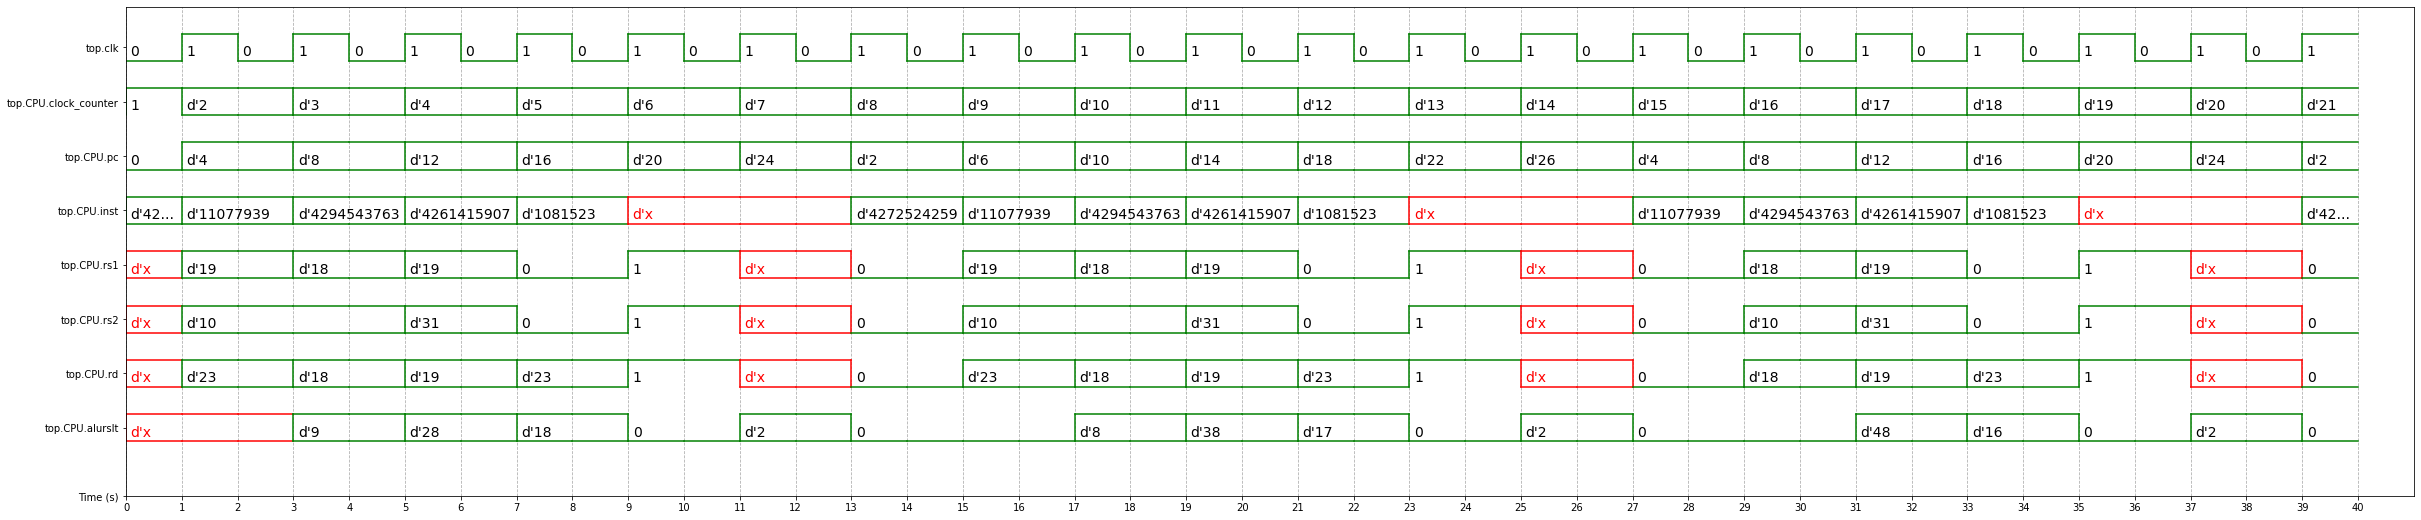

In [ ]:
%%waveform test.vcd

sign_list = ['top.clk','top.CPU.clock_counter','top.CPU.pc','top.CPU.inst', 'top.CPU.rs1','top.CPU.rs2', 'top.CPU.rd','top.CPU.alurslt' ]
time_begin = 0
time_end = 40
base = 'dec' # bin, dec, dec2, hex, octal


### Decode Stage

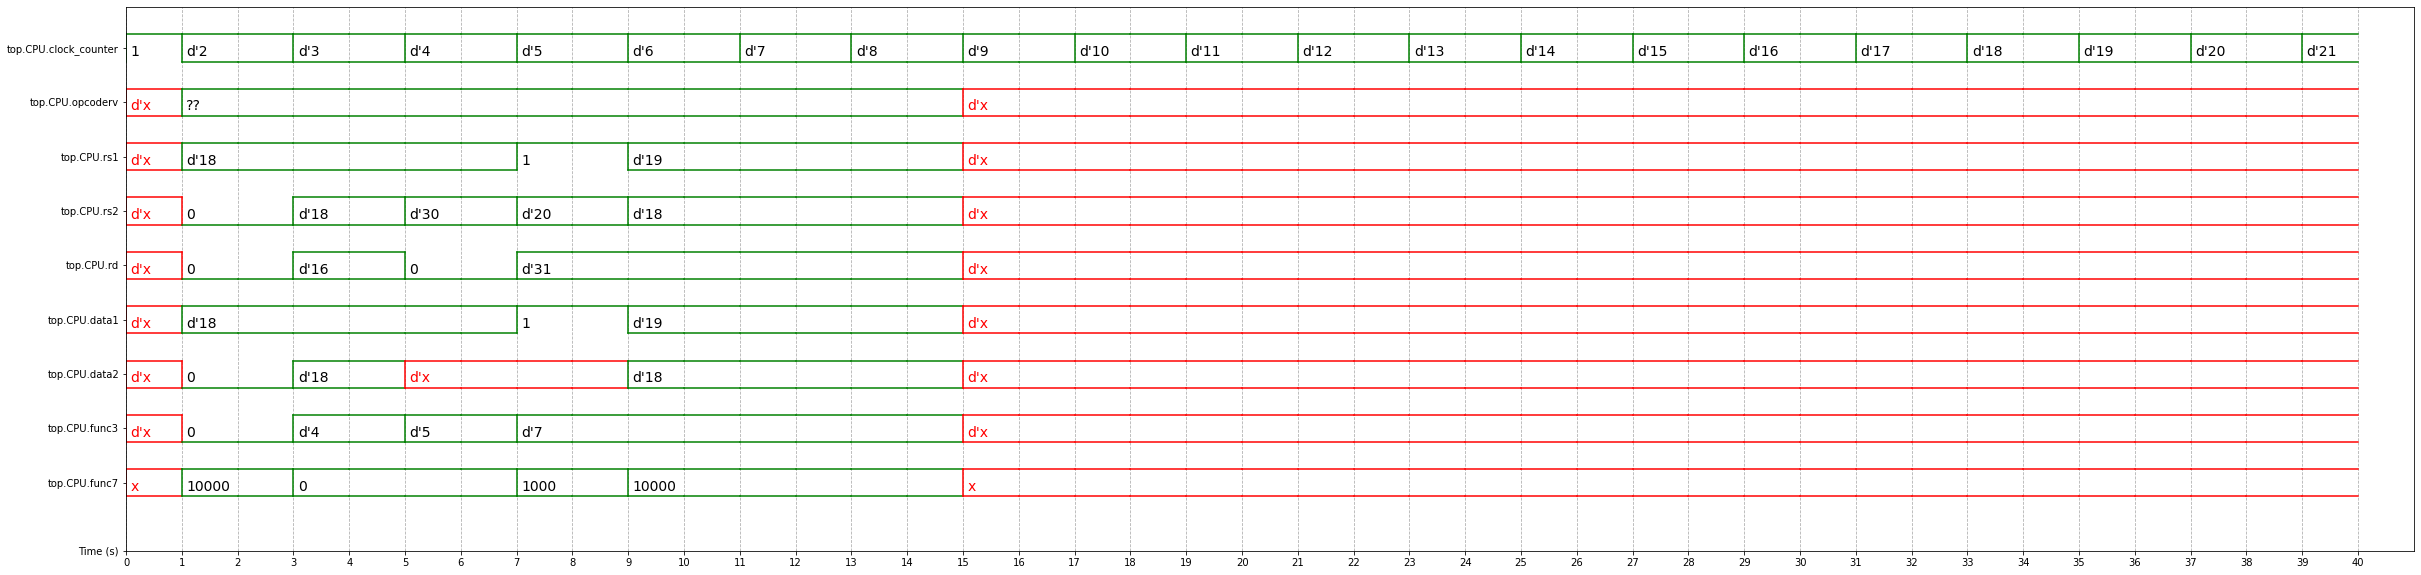

In [ ]:
%%waveform test.vcd

op_dict = [{'110011':'ALU'}, {'10':'sp','111':'t2','1001':'s1', '1000':'s0','110':'t1','100':'tp','1':'ra','11':'gp', '101':'t0'} ]

sign_list = ['top.CPU.clock_counter','top.CPU.opcoderv,r[0]', 'top.CPU.rs1','top.CPU.rs2', 'top.CPU.rd','top.CPU.data1', 'top.CPU.data2' , 'top.CPU.func3', 'top.CPU.func7,b' ]
time_begin = 0
time_end = 40
base = 'dec' # bin, dec, dec2, hex, octal


#### Hazard Unit

### Execute Stage

#### Add and Sub

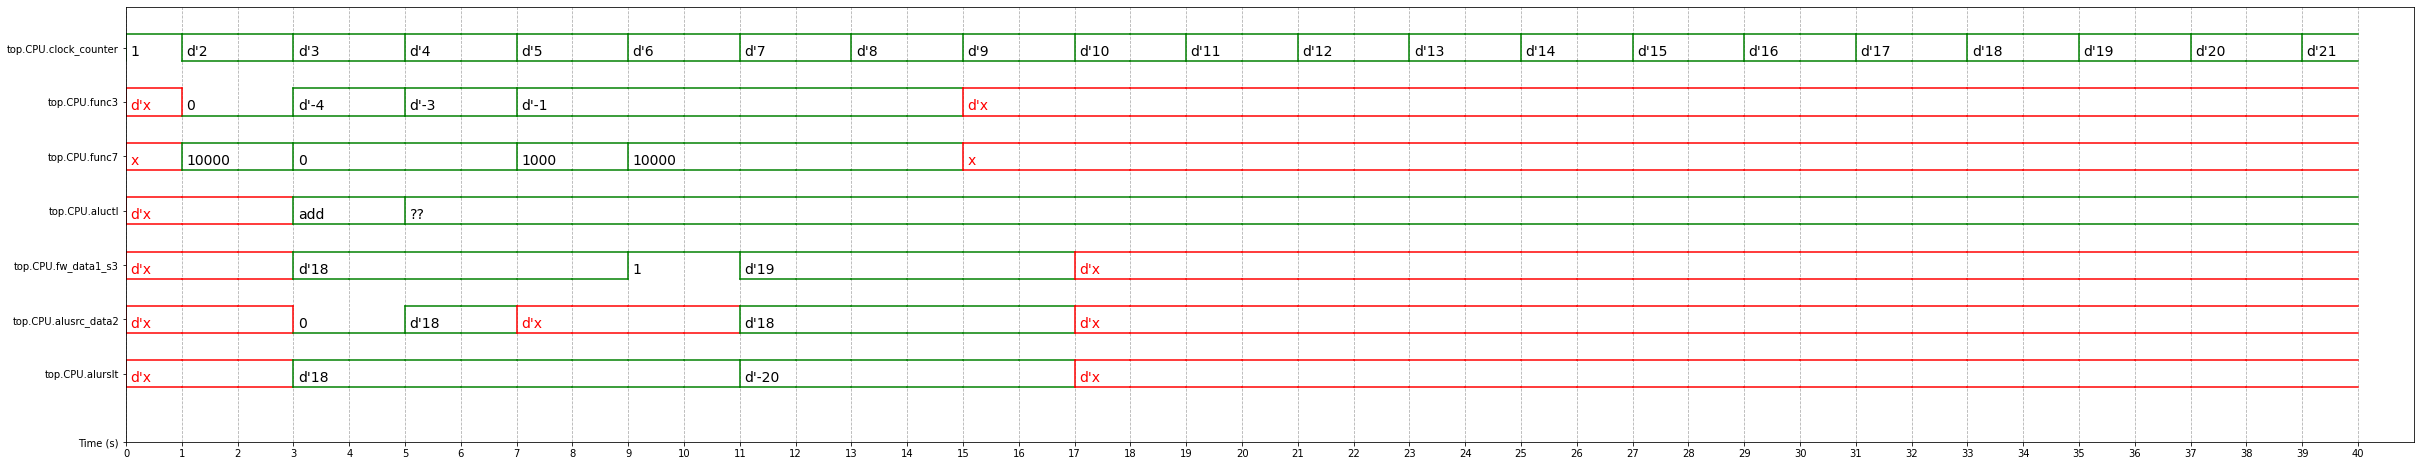

In [ ]:
%%waveform test.vcd

op_dict = [{'10':'add','110':'sub'}, {'10':'sp','111':'t2','1001':'s1', '1000':'s0','110':'t1','100':'tp','1':'ra','11':'gp', '101':'t0'} ]

sign_list = ['top.CPU.clock_counter','top.CPU.func3', 'top.CPU.func7,b', 'top.CPU.aluctl,r[0]' , 'top.CPU.fw_data1_s3', 'top.CPU.alusrc_data2','top.CPU.alurslt']
time_begin = 0
time_end = 40
base = 'dec2' # bin, dec, dec2, hex, octal


#### Forward Unit

In [ ]:
%%writefile simple.s
add x2,x3,x4
sub x3,x5,x1
add x7,x2,x3

Overwriting simple.s


In [ ]:
!rm -f -r simple/*
def assemble():
  cnv = AssemblyConverter(output_type = "t") #just text
  cnv.convert("simple.s")
  # Using readlines()
  file1 = open('simple/txt/simple.txt', 'r')
  Lines = file1.readlines()
  file1 = open('im_data.txt', 'w')


  for line in Lines:
    decimal_representation = int(line, 2)
    hexadecimal_string = hex(decimal_representation)
    file1.write(hexadecimal_string[2:]+'\n')

  file1.close()

assemble()

0
------Writing to Text file------
Output file: simple.txt
Number of instructions: 3


In [ ]:
%%verilog 
`include "main.v"

VCD info: dumpfile test.vcd opened for output.



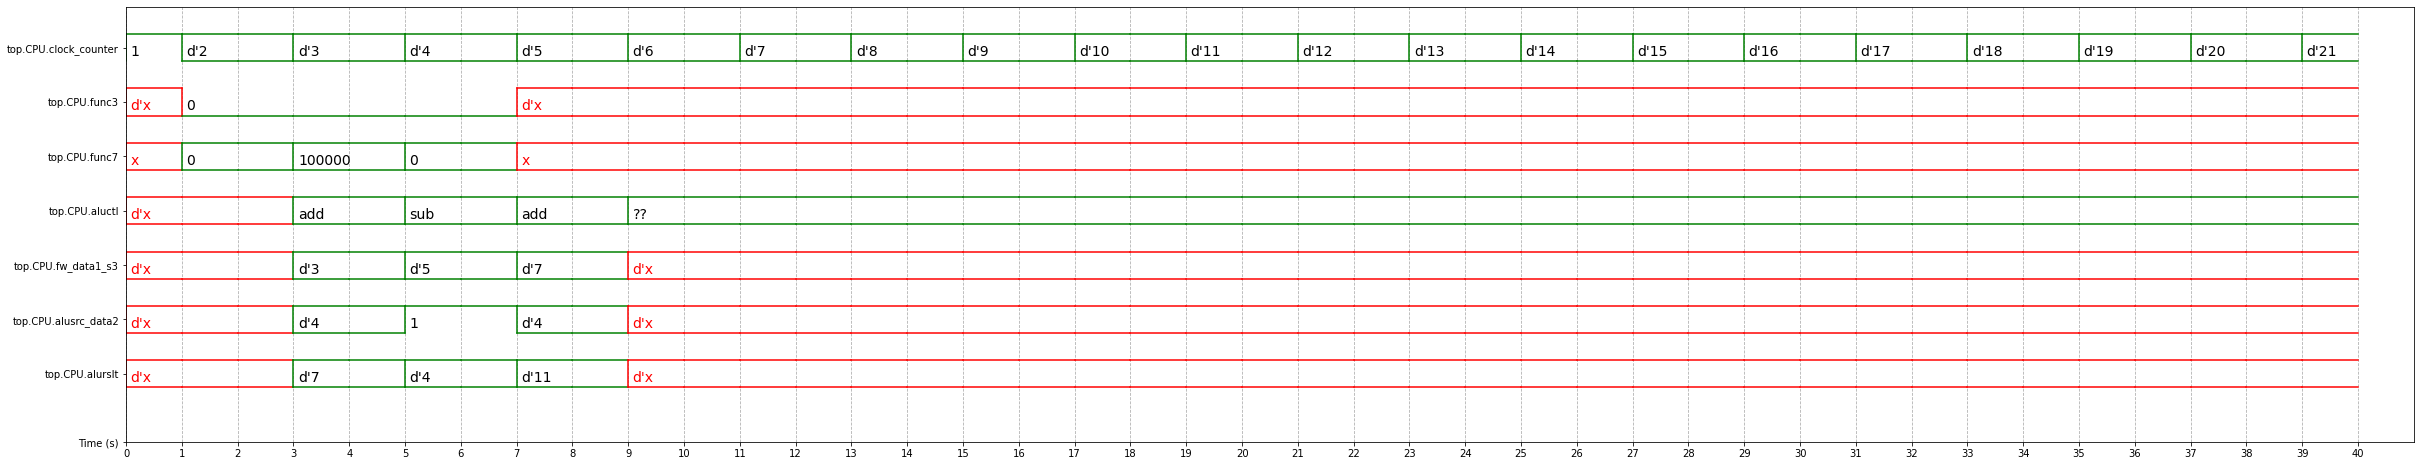

In [ ]:
%%waveform test.vcd

op_dict = [{'10':'add','110':'sub'}, {'10':'sp','111':'t2','1001':'s1', '1000':'s0','110':'t1','100':'tp','1':'ra','11':'gp', '101':'t0'} ]

sign_list = ['top.CPU.clock_counter','top.CPU.func3', 'top.CPU.func7,b', 'top.CPU.aluctl,r[0]' , 'top.CPU.fw_data1_s3', 'top.CPU.alusrc_data2','top.CPU.alurslt']
time_begin = 0
time_end = 40
base = 'dec2' # bin, dec, dec2, hex, octal


#### Addi

In [ ]:
%%writefile simple.s
add x2,x3,x4  
sub x3,x5,x1
add x7,x2,x3
addi x2,x0,5
addi x3,x1,-2

Overwriting simple.s


In [ ]:
!rm -f -r simple/*
assemble()

0
------Writing to Text file------
Output file: simple.txt
Number of instructions: 5


In [ ]:
!cat simple/txt/simple.txt

00000000010000011000000100110011
01000000000100101000000110110011
00000000001100010000001110110011
00000000010100000000000100010011
11111111111000001000000110010011


In [ ]:
%%verilog 
`include "main.v"

VCD info: dumpfile test.vcd opened for output.



##### Decode

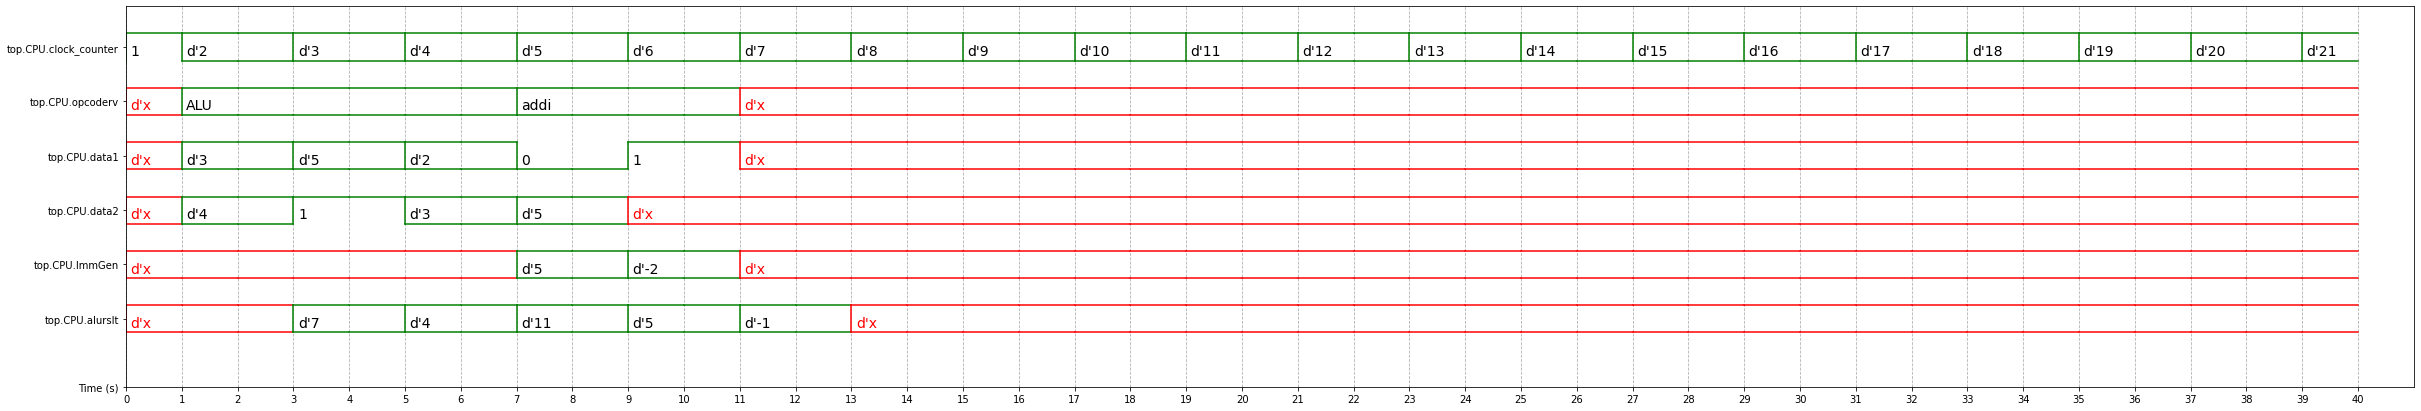

In [ ]:
%%waveform test.vcd

op_dict = [{'10':'add','110':'sub'}, {'110011':'ALU','10011':'addi'},{'10':'sp','111':'t2','1001':'s1', '1000':'s0','110':'t1','100':'tp','1':'ra','11':'gp', '101':'t0'} ]

sign_list = ['top.CPU.clock_counter','top.CPU.opcoderv,r[1]' , 'top.CPU.data1', 'top.CPU.data2','top.CPU.ImmGen', 'top.CPU.alurslt']
time_begin = 0
time_end = 40
base = 'dec2' # bin, dec, dec2, hex, octal


##### Execute


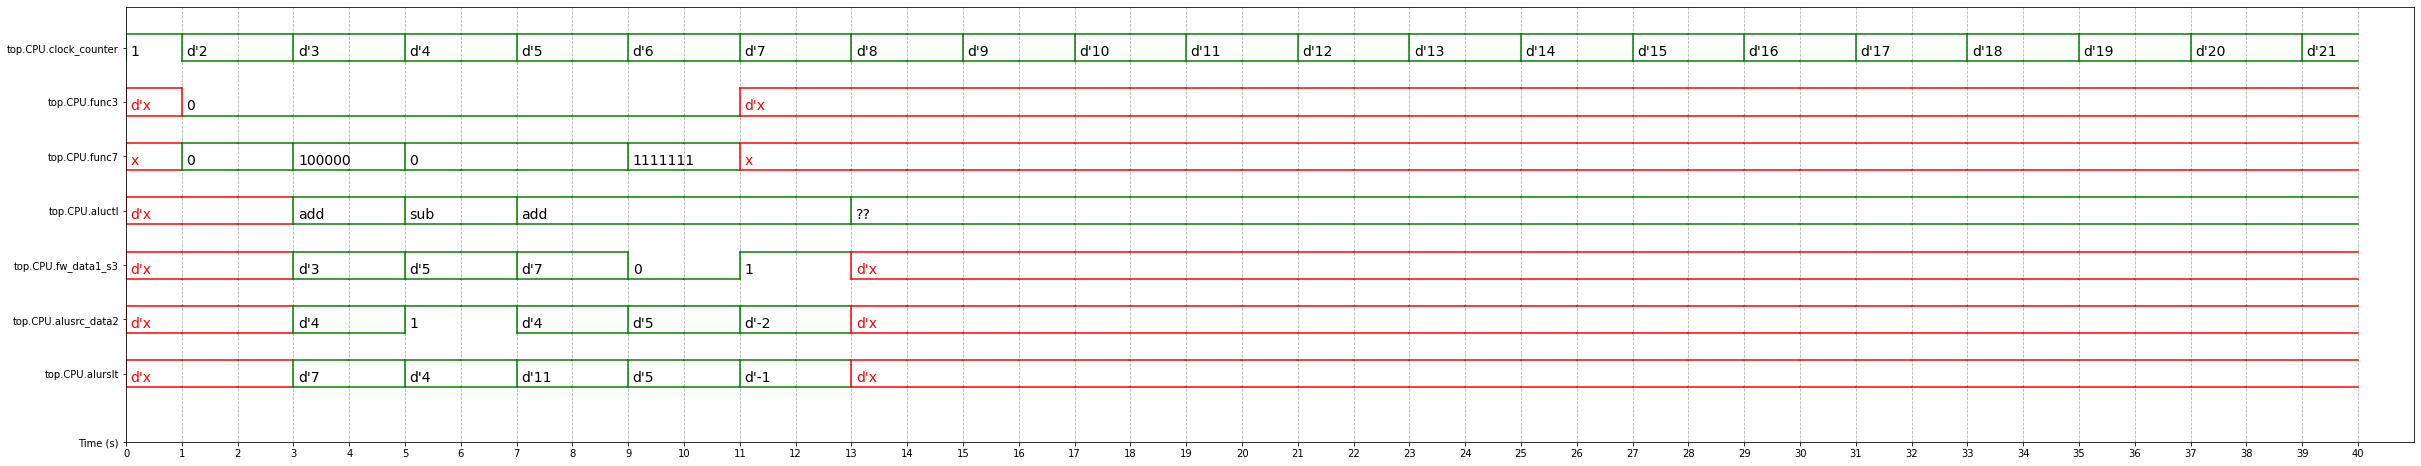

In [ ]:
%%waveform test.vcd

op_dict = [{'10':'add','110':'sub'}, {'10':'sp','111':'t2','1001':'s1', '1000':'s0','110':'t1','100':'tp','1':'ra','11':'gp', '101':'t0'} ]

sign_list = ['top.CPU.clock_counter','top.CPU.func3', 'top.CPU.func7,b', 'top.CPU.aluctl,r[0]' , 'top.CPU.fw_data1_s3', 'top.CPU.alusrc_data2','top.CPU.alurslt']
time_begin = 0
time_end = 40
base = 'dec2' # bin, dec, dec2, hex, octal


##### Segundo Exemplo

In [ ]:
!rm -f -r simple/*
assemble()

0
------Writing to Text file------
Output file: simple.txt
Number of instructions: 5


In [ ]:
%%verilog 
`include "main.v"

VCD info: dumpfile test.vcd opened for output.



In [ ]:
%%writefile simple.s
addi x2,x0,5
addi x3,x1,-2
add x5,x3,x2  

Overwriting simple.s


In [ ]:
# Final Register file
!cat reg.data

// 0x00000000
00000000
00000001
00000005
ffffffff
00000004
00000005
00000006
0000000b
00000008
00000009
0000000a
0000000b
0000000c
0000000d
0000000e
0000000f


#### Load and Store

##### Código de Teste para Load

* x2 = mem[x4+0] = mem[4+0/4] = mem[palavra 1] = 1
* x3 = mem[x4+12] = mem[4+12/4] = mem[palavra 4] = 4
* x1 = mem[x4+-4] = mem[4-4/4] = mem[palavra 0] = 0

Registro
```
0
0
1
4
4
5
6
....
```


In [ ]:
%%writefile simple.s
lw x2,0(x4)
lw x3,12(x4)
lw x1,-4(x4)

Overwriting simple.s


In [ ]:
!rm -f -r simple/*
assemble()

0
------Writing to Text file------
Output file: simple.txt
Number of instructions: 3


In [ ]:
%%verilog 
`include "main.v"

VCD info: dumpfile test.vcd opened for output.



Resultado esperado para o Banco de Registradores
```
0
0
1
4
4
5
6
....
```

In [ ]:
# Final Register file
!cat reg.data

// 0x00000000
00000000
00000000
00000001
00000004
00000004
00000005
00000006
00000007
00000008
00000009
0000000a
0000000b
0000000c
0000000d
0000000e
0000000f


##### Segundo Código de Teste

* lw x1,4(x8)
* add x2,x2,x2
* add x3,x2,x1

```
x1 = mem[4+8/4] = 3
x2 = 2+2 = 4
x3 = 4 + 3 = 7
```

Resultado final esperado para Registradores
```
0
3
4
7
5
6
....
```



In [ ]:
%%writefile simple.s
lw x1,4(x8)
add x2,x2,x2
add x3,x2,x1

Overwriting simple.s


In [ ]:
!rm -f -r simple/*
assemble()

0
------Writing to Text file------
Output file: simple.txt
Number of instructions: 3


In [ ]:
%%verilog 
`include "main.v"

VCD info: dumpfile test.vcd opened for output.



In [ ]:
# Final Register file
!cat reg.data

// 0x00000000
00000000
00000003
00000004
00000007
00000004
00000005
00000006
00000007
00000008
00000009
0000000a
0000000b
0000000c
0000000d
0000000e
0000000f


##### Terceiro Teste do Lw e unidade de Hazard

In [ ]:
%%writefile simple.s
add x2,x2,x2
lw x1,4(x8)
add x3,x2,x1

Overwriting simple.s


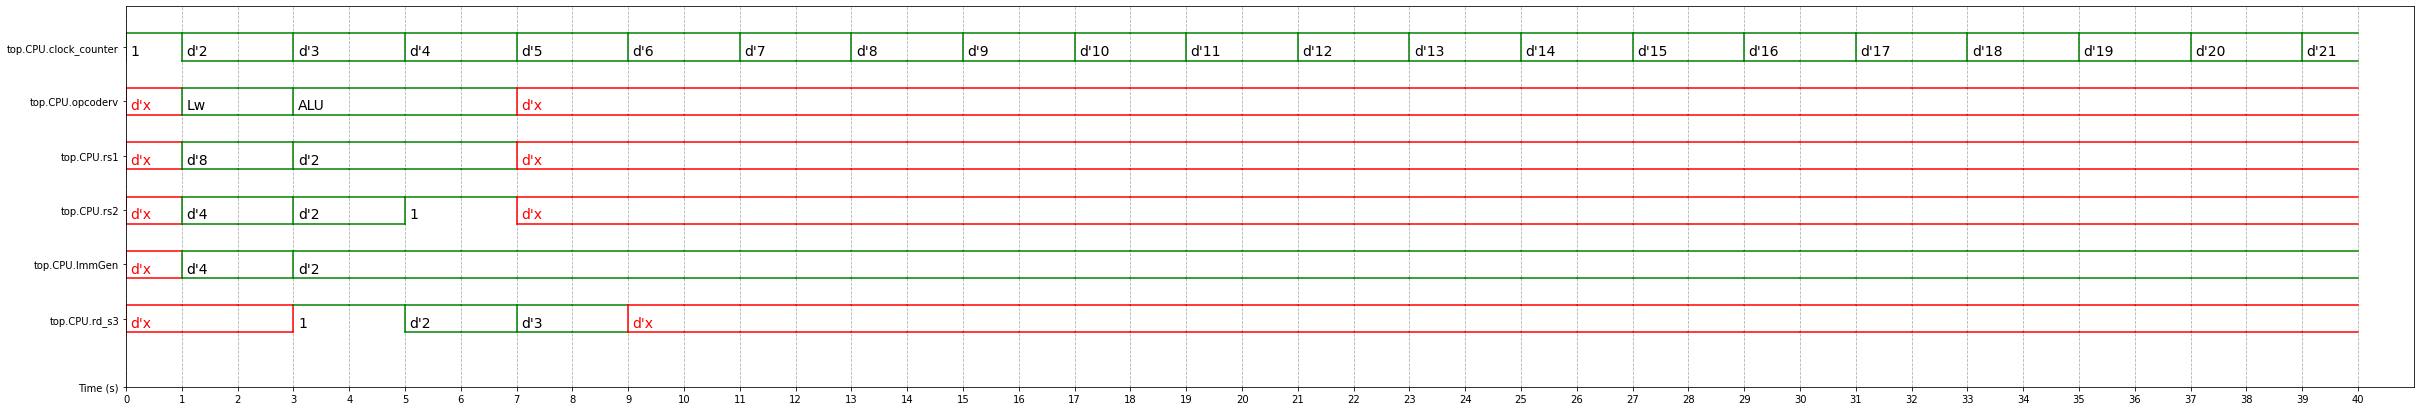

In [ ]:
%%waveform test.vcd

op_dict = [{'10':'add','110':'sub'}, {'110011':'ALU','10011':'addi','11':'Lw'},{'10':'sp','111':'t2','1001':'s1', '1000':'s0','110':'t1','100':'tp','1':'ra','11':'gp', '101':'t0'} ]

sign_list = ['top.CPU.clock_counter','top.CPU.opcoderv,r[1]' , 'top.CPU.rs1', 'top.CPU.rs2','top.CPU.ImmGen', 'top.CPU.rd_s3']
time_begin = 0
time_end = 40
base = 'dec2' # bin, dec, dec2, hex, octal


Resultado final esperado para Registradores
```
0
3
4
7
5
6
....
```

In [ ]:
# Final Register file
!cat reg.data

// 0x00000000
00000000
00000003
00000004
00000007
00000004
00000005
00000006
00000007
00000008
00000009
0000000a
0000000b
0000000c
0000000d
0000000e
0000000f


#### Branches

[Arquivo com os binários dos 2 exemplos](https://raw.githubusercontent.com/arduinoufv/inf251/main/riscv/exemplos_para_desvio.txt)

##### Código de Teste


In [ ]:
%%writefile simple.s
beq x19,x10,8
add x18,x18,x10
addi x19,x19,-1
beq x0,x0,-6
add x1,x1,x1

Overwriting simple.s


In [ ]:
!rm -f -r simple/*
assemble()

0
------Writing to Text file------
Output file: simple.txt
Number of instructions: 5


In [ ]:
!cat simple/txt/simple.txt

11111110101010011000101111100011
00000000101010010000100100110011
11111111111110011000100110010011
11111110000000000000101111100011
00000000000100001000000010110011


In [ ]:
!cat im_data.txt

fea98be3
a90933
fff98993
fe000be3
1080b3


In [ ]:
%%verilog 
`include "main.v"

VCD info: dumpfile test.vcd opened for output.



###### Decode

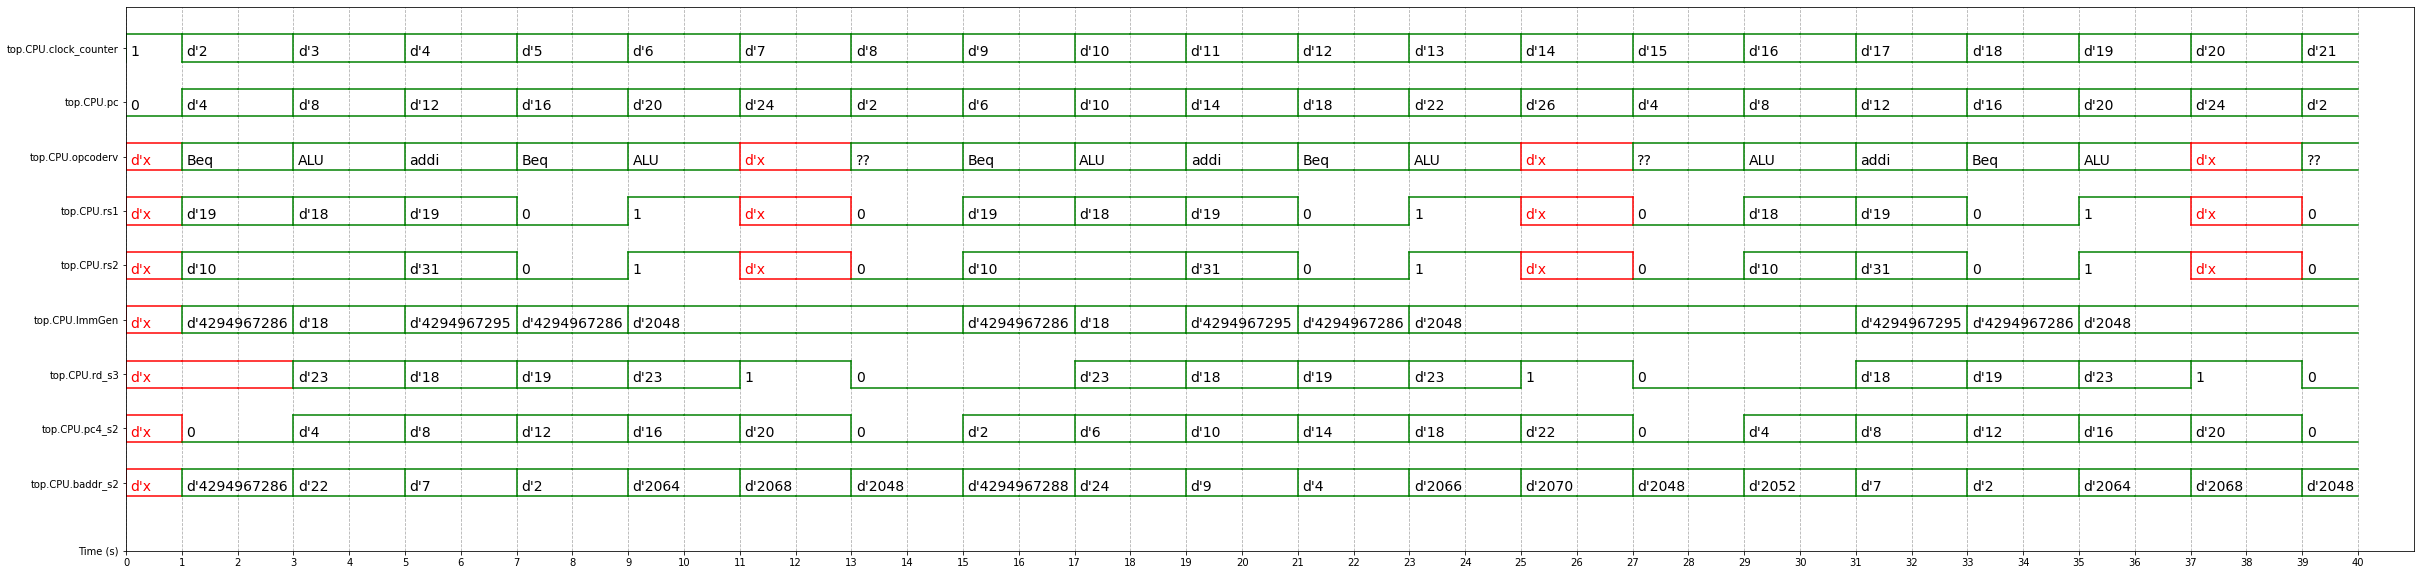

In [ ]:
%%waveform test.vcd

op_dict = [{'10':'add','110':'sub'}, {'110011':'ALU','10011':'addi','11':'Lw', '1100011':'Beq'},{'10':'sp','111':'t2','1001':'s1', '1000':'s0','110':'t1','100':'tp','1':'ra','11':'gp', '101':'t0'} ]

sign_list = ['top.CPU.clock_counter', 'top.CPU.pc', 'top.CPU.opcoderv,r[1]' , 'top.CPU.rs1', 'top.CPU.rs2','top.CPU.ImmGen', 'top.CPU.rd_s3', 'top.CPU.pc4_s2', 'top.CPU.baddr_s2']
time_begin = 0
time_end = 40
base = 'dec' # bin, dec, dec2, hex, octal

##### Segundo Teste BEQ
* 0: nop
* 4: addi x1,x1,1
* 8: beq  x1,x3,4
* 12: beq x0,x0,-4
* 16: sub x1,x1,x4

In [ ]:
%%writefile simple.s
nop
addi x1,x1,1
beq x1,x3,4
beq x0,x0,-4
sub x1,x1,x4

Overwriting simple.s


In [ ]:
!cat simple/txt/simple.txt

11111110101010011000101111100011
00000000101010010000100100110011
11111111111110011000100110010011
11111110000000000000101111100011
00000000000100001000000010110011


In [ ]:
!cat im_data.txt

fea98be3
a90933
fff98993
fe000be3
1080b3


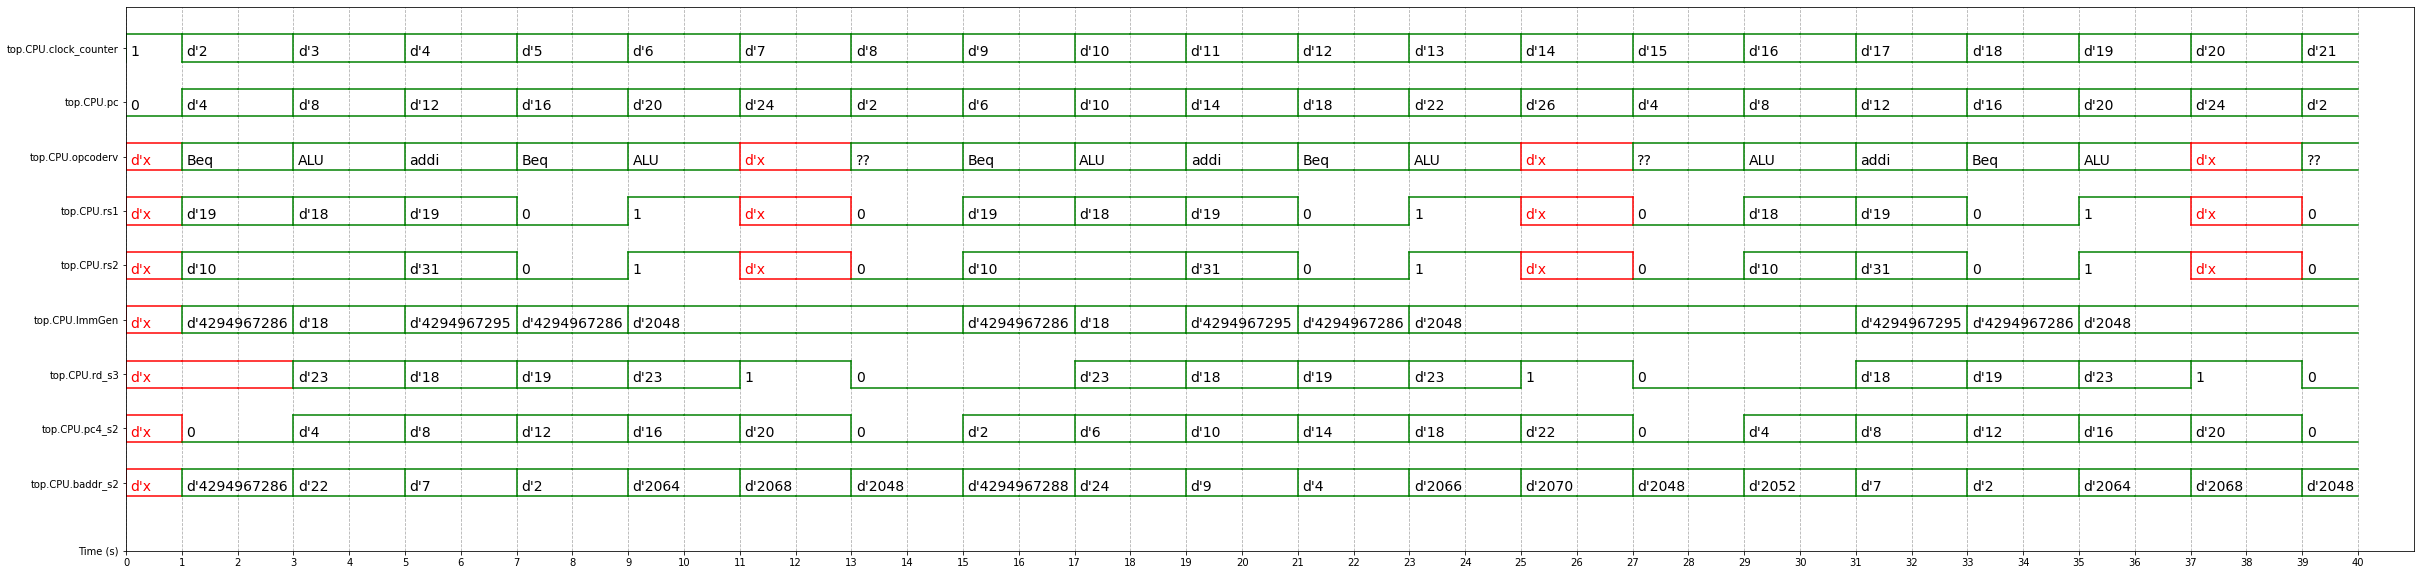

In [ ]:
%%waveform test.vcd

op_dict = [{'10':'add','110':'sub'}, {'110011':'ALU','10011':'addi','11':'Lw', '1100011':'Beq'},{'10':'sp','111':'t2','1001':'s1', '1000':'s0','110':'t1','100':'tp','1':'ra','11':'gp', '101':'t0'} ]

sign_list = ['top.CPU.clock_counter', 'top.CPU.pc', 'top.CPU.opcoderv,r[1]' , 'top.CPU.rs1', 'top.CPU.rs2','top.CPU.ImmGen', 'top.CPU.rd_s3', 'top.CPU.pc4_s2', 'top.CPU.baddr_s2']
time_begin = 0
time_end = 40
base = 'dec' # bin, dec, dec2, hex, octal

###### Explicacao
```
                 4  8  12 16 20 24 4 8 12 16 20 16 20
0  nop           2  3  4  5  6  7  8 9 0  1  2  3  4
4  addi x1,x1,1  F  D  E  M  W     F D E  M  W           
8  beq x1,x3,4      F  D  E  M  W    F D  E  M  W
12 beq x0,x0,-4        F  D  E  M  W   F  D  E 
16 sub x1,x1,x4           F  D  E         F  D  F  D  E  M W
20                           F  D            F     F 
24                              F
```


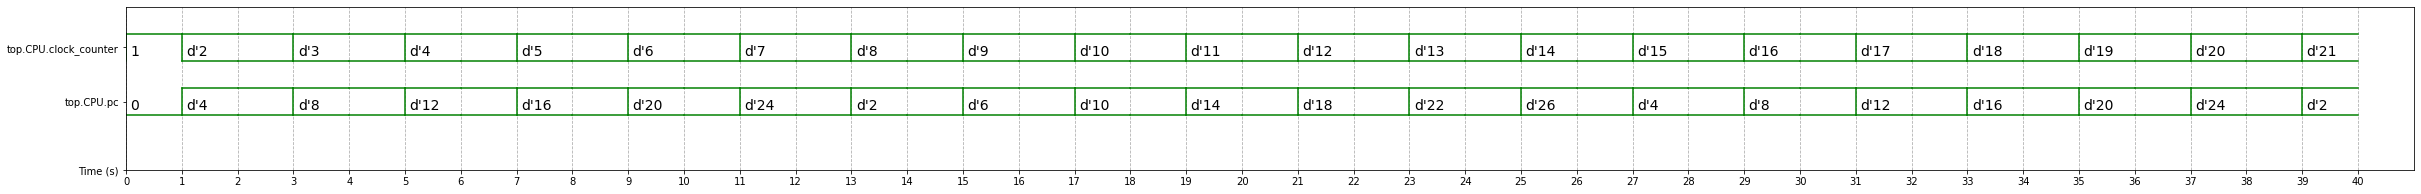

In [ ]:
%%waveform test.vcd

op_dict = [{'10':'add','110':'sub'}, {'10':'sp','111':'t2','1001':'s1', '1000':'s0','110':'t1','100':'tp','1':'ra','11':'gp', '101':'t0'} ]

sign_list = ['top.CPU.clock_counter','top.CPU.pc']
time_begin = 0
time_end = 40
base = 'dec2' # bin, dec, dec2, hex, octal


In [ ]:
# Final Register file
!cat reg.data

// 0x00000000
00000000
00000001
00000002
00000003
00000004
00000005
00000006
00000007
00000008
00000009
0000000a
0000000b
0000000c
0000000d
0000000e
0000000f


### Memory Stage

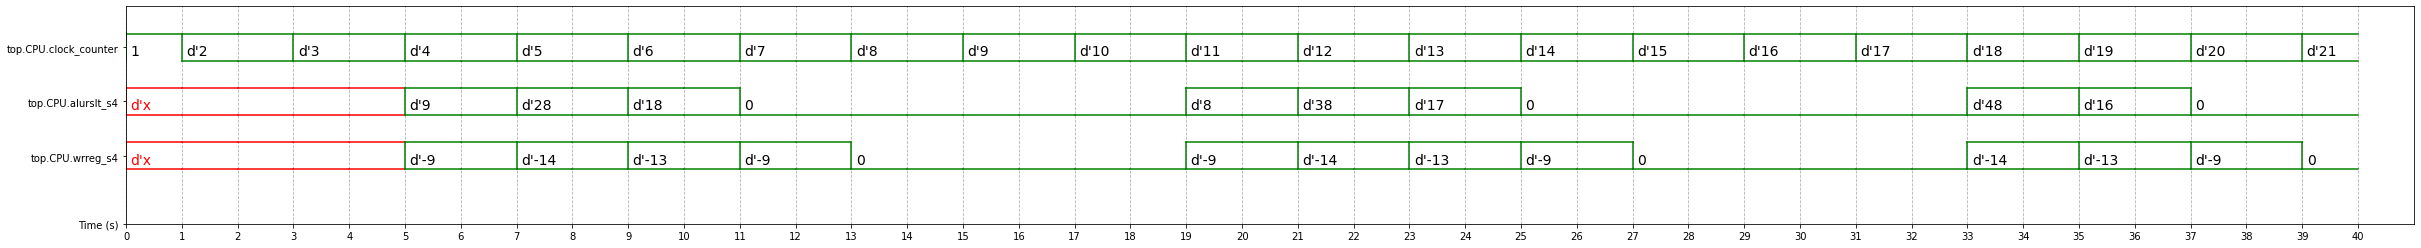

In [ ]:
%%waveform test.vcd

op_dict = [{'10':'add','110':'sub'}, {'10':'sp','111':'t2','1001':'s1', '1000':'s0','110':'t1','100':'tp','1':'ra','11':'gp', '101':'t0'} ]

sign_list = ['top.CPU.clock_counter','top.CPU.alurslt_s4','top.CPU.wrreg_s4']
time_begin = 0
time_end = 40
base = 'dec2' # bin, dec, dec2, hex, octal


### Writback Stage

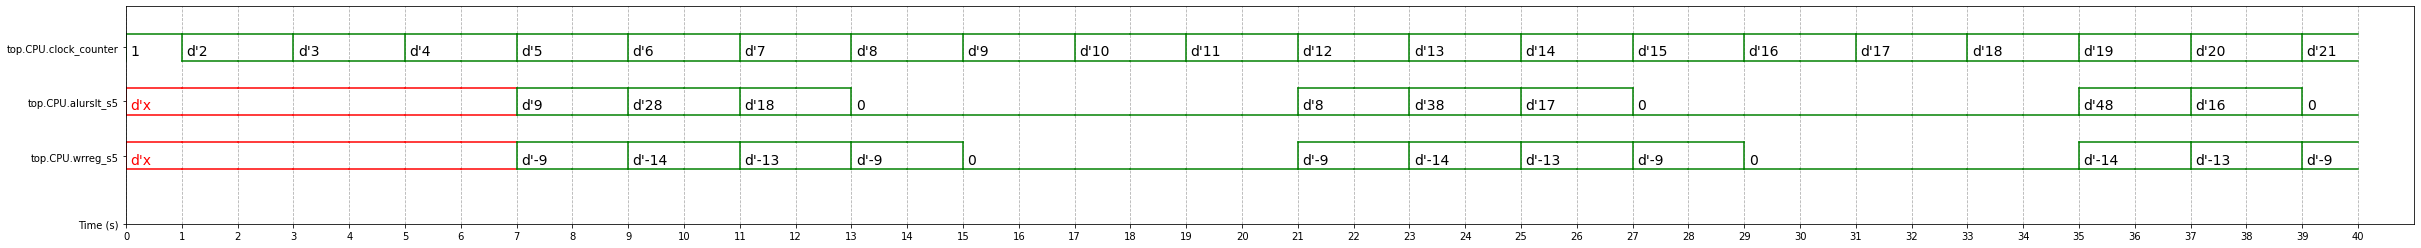

In [ ]:
%%waveform test.vcd

op_dict = [{'10':'add','110':'sub'}, {'10':'sp','111':'t2','1001':'s1', '1000':'s0','110':'t1','100':'tp','1':'ra','11':'gp', '101':'t0'} ]

sign_list = ['top.CPU.clock_counter','top.CPU.alurslt_s5','top.CPU.wrreg_s5']
time_begin = 0
time_end = 40
base = 'dec2' # bin, dec, dec2, hex, octal


In [ ]:
# Final Register file
!cat reg.data

// 0x00000000
00000000
00000001
00000002
00000003
00000004
00000005
00000006
00000007
00000008
00000009
0000000a
0000000b
0000000c
0000000d
0000000e
0000000f


In [ ]:
# Final Data Memory
!cat mem.data 

// 0x00000000
00000000
00000001
00000002
00000003
00000004
00000005
00000006
00000007
00000008
00000009
00000010
00000011
00000012
00000013
00000014
00000015


# Parte I

Instruções de Load e Store

## Código de teste

```
lw x1,4(x4)    // x1 = m[(4+4)/4] = m["2"] = 2
sw x1,-8(x8)   // m[8-8]=m["0"] = x1 = 2
lw x3,4(x4)    // x3 = m[(4+4)/4] = m["2"] = 2
lw x2,4(x12)   // x2 = m[(12+4)/4] = m["4"] = 4
sw x3,0(x16)   // m[(8+8)/4] = m["4"] = x3 = 2
sw x8,12(x12)  // m[(12+12)/4] = m["6"] = x8 = 8
```
Final para Banco de Registradores
```
0
2  <-  novo valor para x1
4  <-  novo valor para x2
2  <-  novo valor para x3
....
```
Final para Memória
```
2   <- novo valor para mem[0]
1
2
3
2   <- novo valor para mem[4]
5
8   <- novo valor para mem[6]
....
```



In [ ]:
%%writefile simple.s
lw x1,4(x4)   
sw x1,-8(x8)
lw x3,4(x4)
lw x2,4(x12)
sw x3,0(x16)
sw x8,12(x12)

Overwriting simple.s


In [ ]:
!rm -f -r simple/*
assemble()

0
------Writing to Text file------
Output file: simple.txt
Number of instructions: 6


In [ ]:
%%verilog 
`include "main.v"

VCD info: dumpfile test.vcd opened for output.



In [ ]:
# Final Registers 
!cat reg.data 

// 0x00000000
00000000
00000002
00000004
00000002
00000004
00000005
00000006
00000007
00000008
00000009
0000000a
0000000b
0000000c
0000000d
0000000e
0000000f


In [ ]:
# Final Data Memory
!cat mem.data 

// 0x00000000
00000002
00000001
00000002
00000003
00000002
00000005
00000008
00000007
00000008
00000009
00000010
00000011
00000012
00000013
00000014
00000015


# Parte II - Branches

Testar loop, branch para frente e para trás. BEQ, BNE e BLT pelo menos.

Codificar os comandos para testar



## Código de teste

```
nop
loop1: addi x1,x1,1
beq x1,x3,loop2
beq x4,x4,loop1
loop2: addi x2,x2,2
blt x5,x2,fim
bne x6,x2,loop2
fim: addi x2,x2,4
```

webrisv:
```
00000000000000000000000000010011
00000000000100001000000010010011
00000000001100001000010001100011
11111110010000100000110011100011
00000000001000010000000100010011
00000000001000101100010001100011
11111110001000110001110011100011
00000000010000010000000100010011

13
00108093
00308463
fe420ce3
00210113
0022c463
fe231ce3
00410113
```

In [ ]:
%%writefile simple.s
loop1: 
  addi x1,x1,1
  beq x1,x3,loop2
  beq x4,x4,loop1
loop2: 
  addi x2,x2,2
  blt x5,x2,fim
  bne x6,x2,fim
fim: 
  addi x2,x2,4

Overwriting simple.s


In [ ]:
!rm -f -r simple/*
assemble()

0
------Writing to Text file------
Output file: simple.txt
Number of instructions: 7


In [ ]:
!cat simple/txt/simple.txt

00000000000100001000000010010011
00000000001100001000010001100011
11111110010000100000101011100011
00000000001000010000000100010011
00000000001000101100010001100011
00000000001000110001001001100011
00000000010000010000000100010011


In [ ]:
!cat im_data.txt

108093
308463
fe420ae3
210113
22c463
231263
410113


In [ ]:
%%verilog 
`include "main.v"

VCD info: dumpfile test.vcd opened for output.



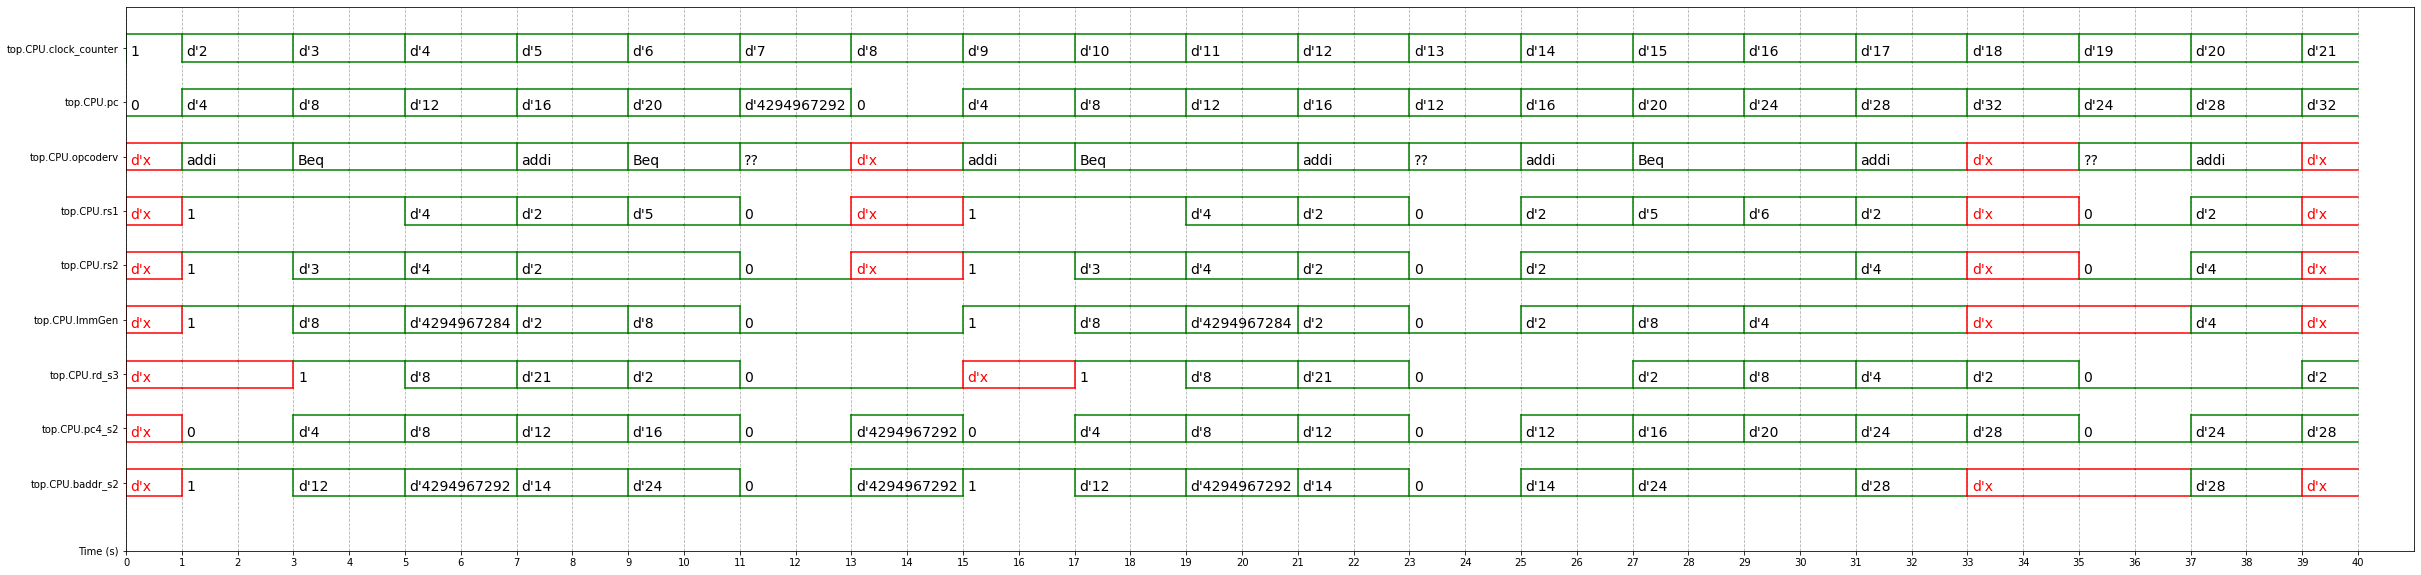

In [ ]:
%%waveform test.vcd

op_dict = [{'10':'add','110':'sub'}, {'110011':'ALU','10011':'addi','11':'Lw', '1100011':'Beq', '000101': 'Bne'},{'10':'sp','111':'t2','1001':'s1', '1000':'s0','110':'t1','100':'tp','1':'ra','11':'gp', '101':'t0'} ]

sign_list = ['top.CPU.clock_counter', 'top.CPU.pc', 'top.CPU.opcoderv,r[1]' , 'top.CPU.rs1', 'top.CPU.rs2','top.CPU.ImmGen', 'top.CPU.rd_s3', 'top.CPU.pc4_s2', 'top.CPU.baddr_s2']
time_begin = 0
time_end = 40
base = 'dec' # bin, dec, dec2, hex, octal

In [ ]:
!cat reg.data

// 0x00000000
00000000
00000003
00000004
00000003
00000004
00000005
00000006
00000007
00000008
00000009
0000000a
0000000b
0000000c
0000000d
0000000e
0000000f


# Parte III - Forward e Hazard

Elaborar exemplos com vários tipos diferentes de dependências e instruções "produtoras" e "consumidoras" (primeiro e segundo operando, distância um e dois da instrução que precisa do dado, caso de Load e Hazard, instrucoes de desvio).


# Parte IV - Códigos dos trabalhos

Executar todos os códigos que o grupo fez em assembler das atividades iniciais e dos códigos com vetores com RiscV. Criar uma subseção para cada código. Mostrar qual o valor esperado em uma célula de texto e depois mostrar qual foi o valor resultante, comprovando o funcionamento. Caso seja necessário alterar o código devido a falta de alguma instrução ou acrescentar alguma instrução no RISCV, comentar. Dizer também quantas instruções foram executadas e quantos ciclos foram necessários para terminar.

Lembre-se que como voce pode colocar um valor inicial na memoria, seu código pode eliminar muitos "addi" e "sw" para preparar o teste, apenas preenchendo o arquivo da memória inicial. 



## Multiplicar usando soma

```
addi x1,x0,5	# x1 = 5
addi x2,x0,3	# x2 = 3
beq x1,x0,fim
beq x2,x0,fim
add x3,x0,x2	# x3 = x2 = 3
addi x1,x1,-1	# x1--
loop: beq x1,x0,fim  # Se x1 = 0 vai para o fim
addi x1,x1,-1	# x1--
add x3,x3,x2	# x3+= x2
beq x0,x0,loop
fim: sw x3,8(gp) # Guarda x3 na mem[3]
```

### Valores iniciais dos registradores e memória

In [ ]:
# Registradores
%%writefile rm_data.txt
0
05
03
03
04
05
06
07
08
09
0A
0B
0C
0D
0E
0F
10
02
03
03

Overwriting rm_data.txt


In [ ]:
# Memória
%%writefile dm_data.txt
0
1
2
03
04
05
06
07
08
09
10
11
12
13
14
15
16
17
18
19

Overwriting dm_data.txt


### Código

webriscv
```
00000000010100000000000010010011
00000000001100000000000100010011
00000010000000001000000001100011
00000000000000010000111001100011
00000000001000000000000110110011
11111111111100001000000010010011
00000000000000001000100001100011
11111111111100001000000010010011
00000000011000011000000110110011
11111110000000000000101011100011
00000000001100011010010000100011

500093
300113
2008063
10E63
2001B3
FFF08093
8863
FFF08093
6181B3
FE000AE3
31A423
```

In [ ]:
!cat im_data.txt

500093
300113
2008063
10E63
2001B3
FFF08093
8863
FFF08093
6181B3
FE000AE3
31A423

In [ ]:
%%verilog 
`include "main.v"

VCD info: dumpfile test.vcd opened for output.



### Resultado

In [ ]:
# Final Registers 
!cat reg.data 

// 0x00000000
00000000
00000004
00000003
00000003
00000004
00000005
00000006
00000007
00000008
00000009
0000000a
0000000b
0000000c
0000000d
0000000e
0000000f


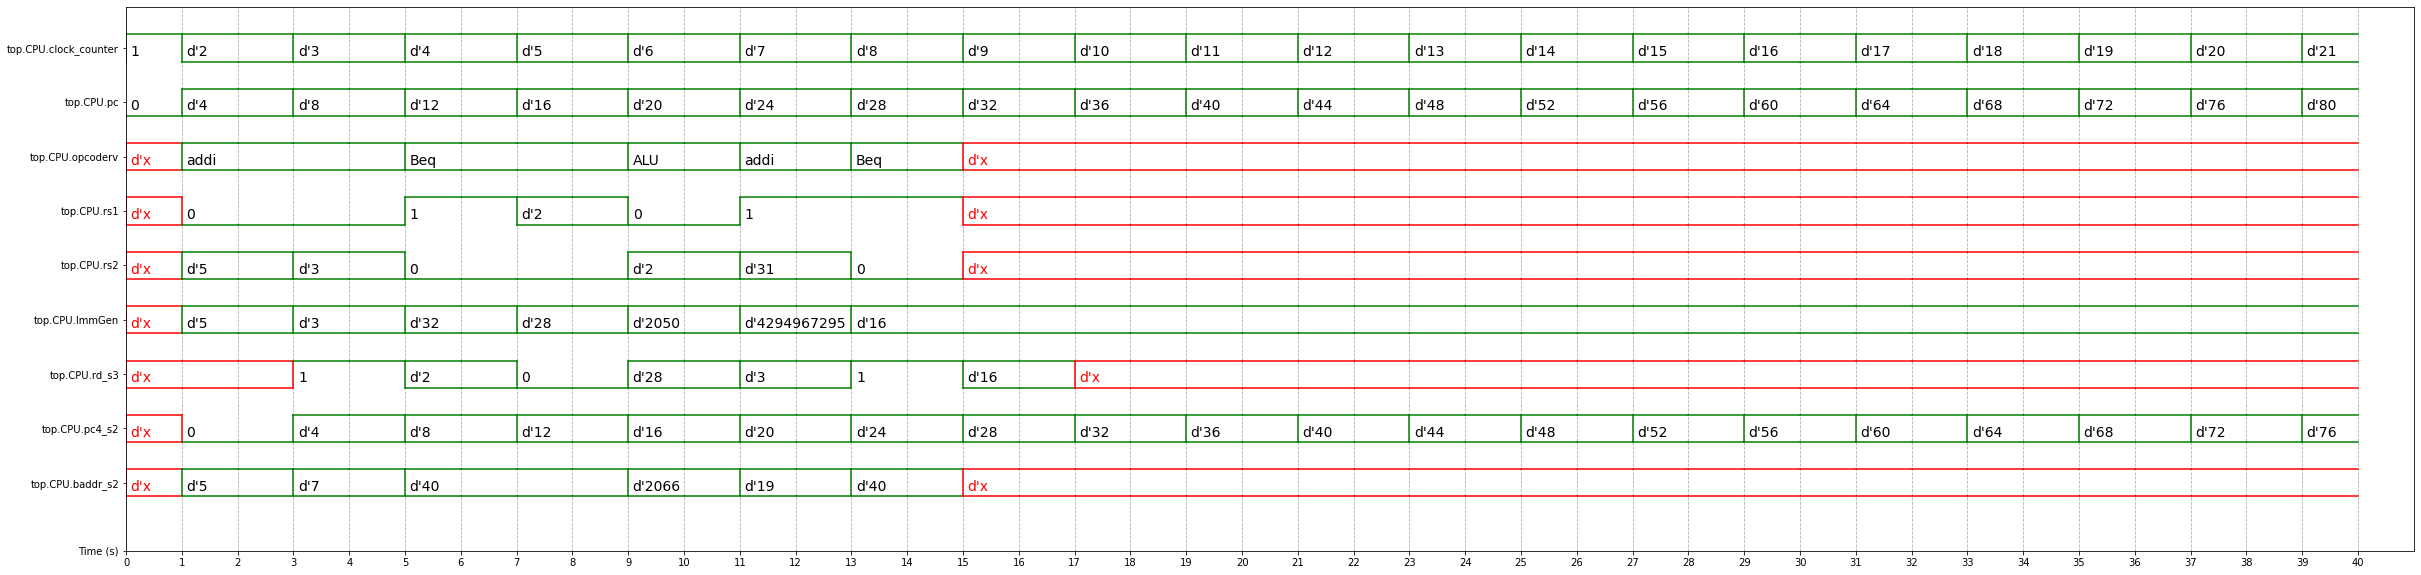

In [ ]:
%%waveform test.vcd

op_dict = [{'10':'add','110':'sub'}, {'110011':'ALU','10011':'addi','11':'Lw', '1100011':'Beq'},{'10':'sp','111':'t2','1001':'s1', '1000':'s0','110':'t1','100':'tp','1':'ra','11':'gp', '101':'t0'} ]

sign_list = ['top.CPU.clock_counter', 'top.CPU.pc', 'top.CPU.opcoderv,r[1]' , 'top.CPU.rs1', 'top.CPU.rs2','top.CPU.ImmGen', 'top.CPU.rd_s3', 'top.CPU.pc4_s2', 'top.CPU.baddr_s2']
time_begin = 0
time_end = 40
base = 'dec' # bin, dec, dec2, hex, octal

In [ ]:
# Final Data Memory
!cat mem.data 

// 0x00000000
00000000
00000001
00000002
00000003
00000004
00000005
00000006
00000007
00000008
00000009
00000010
00000011
00000012
00000013
00000014
00000015
